In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys, os
sys.path.append("../..")
sys.path.append("..")
sys.path.append(os.getcwd())
import re
import datetime

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import seaborn as sns
sns.set()
sns.set(palette="bright")
sns.set_style("whitegrid")

from sklearn import linear_model
from cycler import cycler
from celluloid import Camera

from IPython.display import HTML

import importlib

#importlib.reload(some_module)
from syn_model import *
from filter_data import *


import warnings

import numpy as np
import pandas as pd
import copy
import random


from tslib.src import tsUtils
from tslib.tests import testdata

#warnings.filterwarnings(action='once')

from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation, DBSCAN #For clustering
from sklearn.mixture import GaussianMixture #For GMM clustering

import hdbscan
import plotly.figure_factory as ff
%matplotlib inline
import json

from scipy.stats import kstest

from sklearn.metrics import mean_squared_error
import math


In [4]:

#global settings for graphs        
cc = (cycler(linestyle=['-', '--', '-.',':']) * cycler(color=list('brgcmyk')))
plt.rc('lines', linewidth=2)
plt.rc('axes', prop_cycle=cc)
plt.rcParams.update({'font.size': 14})
plt.rcParams['figure.figsize'] = (8.0, 6.0)

plt.rcParams["animation.html"] = "html5"

In [5]:
from load_and_clean import *

#update_data()

us = load_clean('NYTimes US')
uscases, usdeaths, usstates = load_clean('NYTimes states')
uscounties_cases, uscounties_deaths, uscounties = load_clean('NYTimes counties')
global_cases, global_deaths = load_clean('JHU global')
us_covid_jhu_cases, us_covid_jhu_deaths = load_clean('JHU US')
mobility_data_apple, mobility_data_google, google_social = load_clean('mobility')
sd_data = load_clean('IHME intervention')
all_population, us_population, usstates_population, uscounties_population = load_clean('population')

uscases_pop_adjusted, usdeaths_pop_adjusted = create_population_adjusted_data(uscases, all_population, fast=True), \
                                    create_population_adjusted_data(usdeaths, all_population, show_exception = True, fast=True)
global_cases_pop_adjusted, global_deaths_pop_adjusted = create_population_adjusted_data(global_cases, all_population, fast=True), \
                                    create_population_adjusted_data(global_deaths, all_population, show_exception = True, fast=True)

uscounties_cases_pop_adjusted = create_population_adjusted_data(uscounties_cases, all_population, show_exception = True, county = True, fast=True)
uscounties_deaths_pop_adjusted = create_population_adjusted_data(uscounties_deaths, all_population, county = True, fast=True)

state_reopen = load_clean('state reopen')
#fips_df = pd.read_csv("../COVID/COVID-19/csse_covid_19_data/UID_ISO_FIPS_LookUp_Table.csv")

These countries/region do not have population data:  {'Virgin Islands'}
These countries/region do not have population data:  {'Bahamas', 'China-Hubei', 'China-Beijing', 'United Kingdom-Jersey', 'China-Tianjin', 'Antarctica', 'United Kingdom-Anguilla', 'United Kingdom-Guernsey', 'Canada-Newfoundland and Labrador', 'United Kingdom-Cayman Islands', 'Eswatini', 'China-Liaoning', 'Netherlands-Aruba', 'Burma', 'China-Unknown', 'China-Jilin', 'United Kingdom-Saint Helena, Ascension and Tristan da Cunha', 'China-Qinghai', 'Canada-Ontario', 'United Kingdom-Gibraltar', 'Netherlands-Curacao', 'China-Shanghai', 'Australia-Victoria', 'Australia-Australian Capital Territory', 'Saint Kitts and Nevis', 'Netherlands-Bonaire, Sint Eustatius and Saba', 'France-Guadeloupe', 'China-Xinjiang', 'France-Reunion', 'China-Hunan', 'Slovakia', 'China-Hainan', 'Summer Olympics 2020', 'Congo (Brazzaville)', 'Australia-Queensland', 'China-Inner Mongolia', 'Cabo Verde', 'China-Fujian', 'Canada-Nunavut', 'China-Ningxi

/Users/niloofarbayat/Documents/COVID19-synthetic-control-analysis/synthetic_control_analysis/load_and_clean.py:229: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  county_population = pd.read_csv(_county_pop_local_path, header=[3], skipfooter=6)
/Users/niloofarbayat/Documents/COVID19-synthetic-control-analysis/synthetic_control_analysis/filter_data.py:49: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  cap = df.columns & pop
/Users/niloofarbayat/Documents/COVID19-synthetic-control-analysis/synthetic_control_analysis/filter_data.py:55: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  cap2 = df2.columns &

In [6]:
#Filter data (this part might be overlapping some cells, but it should contain most of the varilables that are analyzed. )
# This part might be to split and explain
# This part might be to split and explain
t = 7
column = list(mobility_data_google.columns).index('retail_and_recreation_percent_change_from_baseline')
global_deaths_filtered = create_filtered_data(global_deaths, 500 )
#the last column of social distancing dataset is the last social distancing measure used by a location
educational_distancing = get_social_distancing(sd_data, sd_data.columns[-1])

all_data = pd.concat([global_deaths, usdeaths, uscounties_deaths], axis=1).dropna()
all_data_daily = create_rolling_data(all_data, t)

all_data_cases = pd.concat([global_cases, uscases, uscounties_cases], axis=1).dropna()
all_data_cases_daily = create_rolling_data(all_data_cases, t)

all_cases_data_pop = pd.concat([uscases_pop_adjusted,global_cases_pop_adjusted, uscounties_cases_pop_adjusted], axis = 1).dropna()
all_cases_data_pop_daily = create_rolling_data(all_cases_data_pop, t)

all_death_data_pop = pd.concat([usdeaths_pop_adjusted,global_deaths_pop_adjusted, uscounties_deaths_pop_adjusted], axis = 1).dropna()
all_death_data_pop_daily = create_rolling_data(all_death_data_pop, t)

_, daily_global, intervention_date_global = create_intervention_adjusted_data(global_deaths, educational_distancing, t)
_, daily_us, intervention_date_us = create_intervention_adjusted_data(usdeaths, educational_distancing, t)
_, daily_uscounties, intervention_date_uscounties = create_intervention_adjusted_data(uscounties_deaths, educational_distancing, t)

cases_intervention_adjusted, cases_intervention_adjusted_daily, intervention_date_case = create_intervention_adjusted_data(all_data_cases, educational_distancing, t)
deaths_intervention_adjusted, deaths_intervention_adjusted_daily, intervention_date_death = create_intervention_adjusted_data(all_data, educational_distancing, t)

all_cases_data_pop_adjusted, all_cases_data_pop_adjusted_daily, _ = create_intervention_adjusted_data(all_cases_data_pop, educational_distancing, t)
all_death_data_pop_adjusted, all_death_data_pop_adjusted_daily, _ = create_intervention_adjusted_data(all_death_data_pop, educational_distancing, t)


last date
Exceptions are []


,Alabama,Alaska,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,District of Columbia,Florida,...,Romania,Slovenia,Spain,Sweden,Switzerland,United Kingdom,King-Washington,Los Angeles-California,New York City-New York,Santa Clara-California
0,332.844875,139.430930,160.605228,127.576211,27.004302,248.665679,19.072798,106.802059,568.190674,477.703959,...,29.043400,165.231751,167.994201,116.952249,265.476816,194.478720,517.582261,23.010015,7.569813e+03,71.582258
1,375.266281,155.834569,178.328131,135.529014,32.470965,301.281392,26.926304,122.206202,701.382503,537.160875,...,40.035520,185.582876,214.182911,129.096505,325.812456,230.878234,567.298567,29.086252,9.174768e+03,80.400363
2,408.917877,164.036389,194.127619,148.783685,39.076516,357.891037,44.596690,146.852831,830.323529,574.641546,...,45.682847,200.603944,253.090006,143.894128,365.392635,272.221082,603.698005,34.963269,1.231714e+04,90.774603
3,448.076097,181.806998,219.818960,168.334325,46.846263,401.997938,54.413572,169.445574,925.258130,634.191582,...,51.884823,214.171360,299.666496,158.487646,491.735465,319.566549,700.911140,41.936001,1.423339e+04,98.036571
4,509.464766,195.476697,243.037337,186.890865,56.691318,456.350144,62.547559,219.765775,1072.619302,686.245483,...,65.145959,232.584283,386.981255,176.857109,638.833756,368.708196,812.328934,53.391203,1.566213e+04,101.667555
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
724,264076.513532,333092.290973,274366.622579,275395.950168,228671.036808,232214.847147,204667.113755,265478.082985,192790.921418,272137.236805,...,141530.150503,445186.668269,240885.975304,251569.696142,366921.299157,307064.321304,164291.973214,280161.173698,1.406420e+06,166510.707253
725,264128.112645,333878.298669,274366.622579,275597.089804,228891.373690,232631.084321,204667.113755,265562.292301,193004.878505,272199.999469,...,141719.184713,447245.523722,241373.175721,251720.529845,370793.640527,308478.774800,164549.432657,280342.962775,1.406925e+06,166626.898745
726,264180.731504,333878.298669,274366.622579,275679.600133,228931.589093,232930.455572,204667.113755,265640.339959,193159.324349,272262.715574,...,141878.923412,448664.287846,241800.787530,251720.529845,370793.640527,308478.774800,164549.432657,280414.682302,1.406925e+06,166626.898745
727,264209.488322,334634.233027,274366.622579,275765.092763,229010.577309,233092.643941,204894.023959,265679.363788,193159.324349,272372.689916,...,141991.920388,450153.796357,241800.787530,251720.529845,370793.640527,308478.774800,164549.432657,280511.304442,1.408276e+06,166626.898745


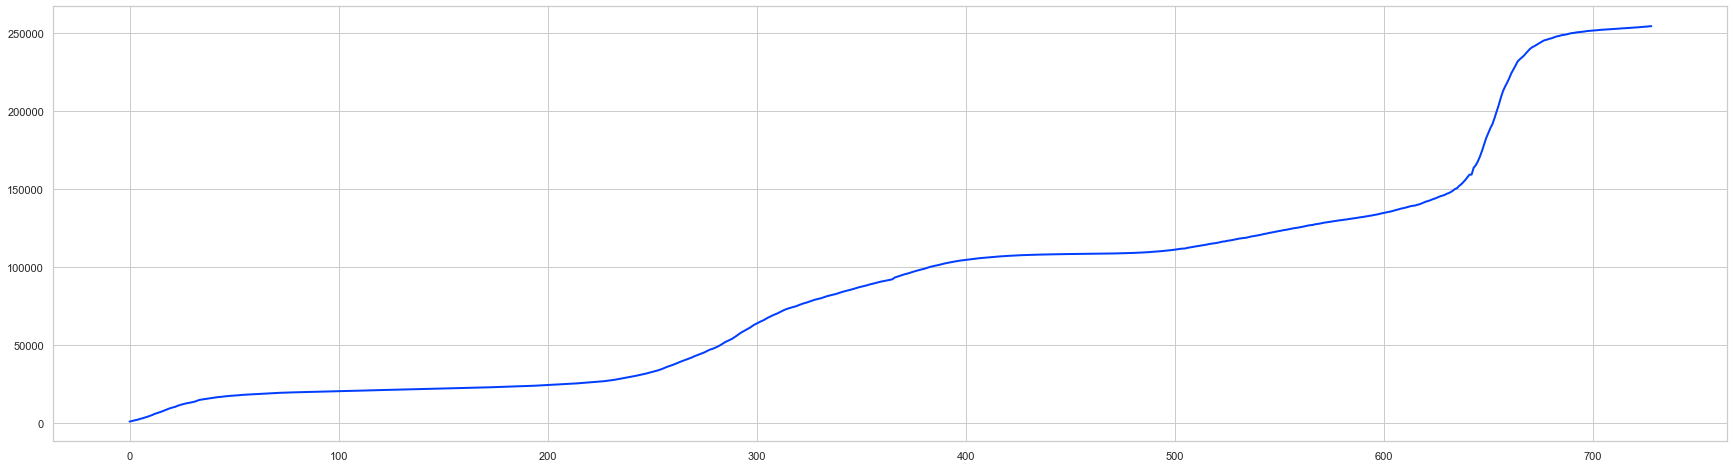

In [41]:
all_cases_data_pop_adjusted['New York'].plot()
all_cases_data_pop_adjusted

In [7]:
masks_mandated = ['New York', 'Maine', 'Maryland', 'Virginia', 'New Mexico', 'California', 'Michigan', 'Illinois', 'Massachusetts','Delaware', 'Rhode Island']
masks_recommended = ['Montana', 'Idaho', 'Utah', 'Arizona', 'North Dakota', 'South Dakota', 'Kansas', 'Oklahoma', 
                     'Texas', 'North Carolina', 'South Carolina', 'West Virginia', 'Wisconsin','Iowa', 'Missouri', 'Alaska']
eu_countries = ['Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'Czechia', 'Denmark',
   'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Ireland',
   'Italy', 'Latvia', 'Lithuania', 'Luxembourg', 'Malta', 'Netherlands',
   'Poland', 'Portugal', 'Romania', 'Slovenia', 'Spain', 'Sweden']

northeast = ["Connecticut","Maine","Massachusetts","New Hampshire",
             "Rhode Island","Vermont","New Jersey","New York",
             "Pennsylvania", "Delaware","District of Columbia","Maryland"]
midwest = ["Indiana","Illinois","Michigan","Ohio","Wisconsin",
             "Iowa","Kansas","Minnesota","Missouri","Nebraska",
             "North Dakota","South Dakota"]
south = ["Florida","Georgia",
            "North Carolina","South Carolina","Virginia",
            "West Virginia","Alabama","Kentucky","Mississippi",
            "Tennessee","Arkansas","Louisiana","Oklahoma","Texas"]

west= ["Arizona","Colorado","Idaho","New Mexico","Montana",
            "Utah","Nevada","Wyoming","Alaska","California",
            "Hawaii","Oregon","Washington"]

california_rollback = ["Fresno-California", "Imperial-California", "Kern-California", "Kings-California", "Los Angeles-California", "San Joaquin-California" , "Tulare-California",
                      "Riverside-California", "Sacramento-California", "San Bernardino-California", "Santa Barbara-California", "Santa Clara-California", "Contra Costa-California", "Stanislaus-California", 
                       "Ventura-California"]

google_counties = ['San Mateo-California', 'San Francisco-California', 'Santa Clara-California']

In [8]:
def _create_dir(path):
    if not os.path.exists(path):
        os.mkdir(path)
_create_dir("../data/vaccination")


_vaccine_state_web_path = "https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/vaccinations/us_state_vaccinations.csv"
_vaccine_state_local_path = "../data/vaccination/us_state_vaccinations.csv"

_vaccine_global_web_path = "https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/vaccinations/vaccinations.csv"
_vaccine_global_local_path = "../data/vaccination/vaccinations.csv"


def _update_vaccination_data(local_path = _vaccine_state_local_path, web_path = _vaccine_state_web_path):
    vaccine_hidden_path = "../data/vaccination/.us_vaccine.csv";
    return_value = os.system("curl -o %s -z %s %s" % (vaccine_hidden_path, vaccine_hidden_path, web_path))
    if return_value != 0:
        print("Unable to update vaccination data (%d)" % return_value, file=sys.stderr)
        return 1
    return_value_copy = os.system(powershell_path + "cp %s %s" % (vaccine_hidden_path, local_path))
    if return_value_copy != 0:
        print("Unable to update vaccination data (copy: %d)" % return_value_copy, file=sys.stderr)
        return 1
    return 0


def _import_vaccination_data(local_path = _vaccine_state_local_path):
    def interpolate_missing_vaccine(vaccine_data):
        cols = vaccine_data.columns
        vaccine_data[cols] = vaccine_data[cols].replace(0,np.nan)
        vaccine_data = vaccine_data.interpolate(method='linear', limit_direction='backward', axis=0)
        return vaccine_data
    
    regions = pd.read_csv(local_path)

    regions["location"].replace({"New York State": "New York"}, inplace=True)
    vaccine = regions.pivot(index='date', columns='location', values='people_vaccinated')
    full_vaccine = regions.pivot(index='date', columns='location', values='people_fully_vaccinated')

    # for region in regions:
    #     cases[region] = cases[regions[region]].sum(axis = 1)
    #     deaths[region] = deaths[regions[region]].sum(axis = 1)
    #vaccine = vaccine.fillna(0)
    #full_vaccine = full_vaccine.fillna(0)
    
    
    
    return interpolate_missing_vaccine(vaccine), interpolate_missing_vaccine(full_vaccine), regions

    
    '''
    vaccine_state = pd.read_csv(_NYTimes_local_path + "us_vaccine.csv")[1:]

    counties['county_state'] = counties['county']+'-'+counties['state']
    cases = counties.pivot_table(index='date', columns='county_state', values='cases')
    deaths = counties.pivot_table(index='date', columns='county_state', values='deaths')
    cases = cases.fillna(0)
    deaths = deaths.fillna(0)

    return cases, deaths, counties
    '''


# Omicron combined with vaccination data

In [9]:
_update_vaccination_data()
vaccine_US, full_vaccine_US,regions_US = _import_vaccination_data(local_path = _vaccine_state_local_path)


full_vaccine_US = full_vaccine_US.reindex(all_cases_data_pop.index, fill_value=0)
vaccine_US = vaccine_US.reindex(all_cases_data_pop.index, fill_value=0)


vaccine_pop_US, full_vaccine_pop_US = create_population_adjusted_data(vaccine_US, all_population, fast=True), \
                                    create_population_adjusted_data(full_vaccine_US, all_population, show_exception = True, fast=True)


These countries/region do not have population data:  {'Republic of Palau', 'Federated States of Micronesia', 'Veterans Health', 'Bureau of Prisons', 'Indian Health Svc', 'Long Term Care', 'United States', 'Virgin Islands', 'Dept of Defense'}


/Users/niloofarbayat/Documents/COVID19-synthetic-control-analysis/synthetic_control_analysis/filter_data.py:49: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  cap = df.columns & pop
/Users/niloofarbayat/Documents/COVID19-synthetic-control-analysis/synthetic_control_analysis/filter_data.py:55: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  cap2 = df2.columns & pop


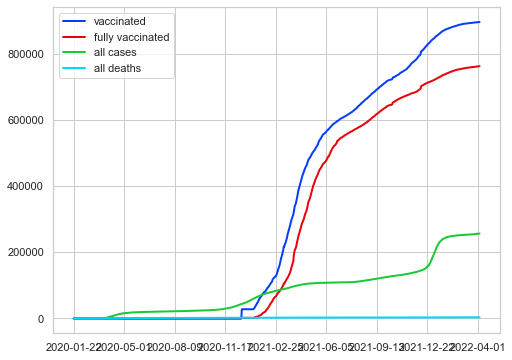

In [10]:
vaccine_pop_US['New York'].plot(label = "vaccinated")

full_vaccine_pop_US['New York'].plot(label = "fully vaccinated")
all_cases_data_pop['New York'].plot(label = "all cases")
all_death_data_pop['New York'].plot(label = "all deaths")
plt.legend()
plt.show()


# Hypothesis testing (diagnostic test using representer's theorem)

In [36]:
import scipy as sp

def passed_H0(donors, target, singval, alpha = 0.05, df= pd.DataFrame(), low_thresh=20, train=pd.DataFrame(), test=pd.DataFrame()):
    if train.empty:
        if df.empty:
            return False
        train, test = df.loc[0:low_thresh], df.loc[low_thresh:]
    
    Y_pre = train[donors]#.values
    #Y_pre = Y_pre[donors]
    Y_post = test[donors]

    x_new = train[target]
    
    
    r_pre = singval #  rank(M_pre) = r_pre (check) ???
    r_post = r_pre # ???

    u_pre, _, v_pre = sp.sparse.linalg.svds(Y_pre, k = singval)
    v_pre = v_pre.T # to make the dimensions match based on Dennis: v_pre should be Nxr_pre
    
    _, _, v_post = sp.sparse.linalg.svds(Y_post, k = singval)
    v_post = v_post.T # to make the dimensions match based on Dennis: v_post should be Nxr_post
    
    
    tau_hat = np.linalg.norm(v_post - np.matmul(np.matmul(v_pre, v_pre.T),v_post))**2/np.linalg.norm(v_post)**2 # computed through Frobenius norm

    tau_pre = np.linalg.norm(x_new - np.matmul(np.matmul(u_pre, u_pre.T),x_new))**2/np.linalg.norm(x_new)**2 # computed through Frobenius norm
    
    print(tau_pre, alpha * r_post, tau_pre < alpha * r_post)
    for t in Y_post.index:
        tau_post = np.linalg.norm(Y_post.loc[t] - np.matmul(np.matmul(v_pre, v_pre.T),Y_post.loc[t]))**2/np.linalg.norm(Y_post.loc[t])**2 # computed through Frobenius norm
        print(tau_post, alpha * r_post, tau_post < alpha * r_post)
        
    
    print(tau_hat,alpha * r_post )
    
    H_0 = tau_hat < alpha * r_post
    return H_0


    # test statistic:
    # tau_hat = np.linalg.norm(v_post - np.matmul(np.matmul(v_pre, v_pre.T),v_post)) # computed through Frobenius norm





In [12]:
# source : https://www.nbcchicago.com/news/local/the-omicron-variant-is-confirmed-in-16-us-states-heres-where-and-what-we-know-about-each-case/2700769/
# https://www.beckershospitalreview.com/public-health/states-where-the-omicron-variant-has-been-detected.html
omincron_variant_data_US = {'Alabama': '2021-12-16',
                            'Alaska':'2021-12-13',
                            'Arizona': '2021-12-08',
                            'Arkansas': '2021-12-17',
                            'California': '2021-12-01',
                            'Colorado': '2021-12-02',
                            'Connecticut': '2021-12-04',
                            'Delaware': '2021-12-17',
                            'Florida': '2021-12-07',
                            'Georgia': '2021-12-03',
                            'Hawaii': '2021-12-02',
                            'Idaho': '2021-12-10',
                            'Illinois': '2021-12-07',
                            'Indiana': '2021-12-19',
                            'Iowa': '2021-12-09',
                            'Kansas': '2021-12-16',
                            'Kentucky': '2021-12-17', # https://www.wymt.com/2021/12/17/first-case-omicron-variant-confirmed-kentucky/
                            'Louisiana': '2021-12-03',
                            'Maine': '2021-12-17',
                            'Maryland': '2021-12-03',
                            'Massachusetts': '2021-12-04',
                            'Michigan': '2021-12-09',
                            'Minnesota': '2021-12-02',
                            'Mississippi': '2021-12-06',
                            'Missouri': '2021-12-03',
                            'Montana': '2021-12-20',
                            'Nebraska': '2021-12-03',
                            'New Hampshire': '2021-12-13',
                            'New Jersey': '2021-12-03', #https://www.inquirer.com/news/omicron-first-new-jersey-case-gov-murphy-20211204.html
                            'New Mexico': '2021-12-13', 
                            'Nevada':'2021-12-13', 
                            'New York': '2021-12-02',
                            'North Carolina': '2021-12-10',
                            'North Dakota': '2021-12-19',
                            'Ohio':  '2021-12-10',
                            'Oklahoma': '2021-12-21',
                            'Oregon': '2021-12-13',
                            'Pennsylvania': '2021-12-03',
                            'Rhode Island':'2021-12-11',
                            'South Carolina': '2021-12-15',
                            'South Dakota': '2021-12-22',
                            'Tennessee': '2021-12-11',
                            'Texas': '2021-12-06', # https://www.kxan.com/news/texas/texas-announces-first-detected-case-of-omicron-variant-in-harris-county/
                            'Utah': '2021-12-03',
                            'Vermont':'2021-12-18',
                            'Virginia': '2021-12-09',
                            'Wisconsin': '2021-12-04',
                            'Washington': '2021-12-04',
                            'District of Columbia': '2021-12-12',
                            'West Virginia':'2021-12-16',
                            'Wyoming':'2021-12-17',
                     }



omicron_date_diff = {key: 
                      (datetime.datetime.strptime(omincron_variant_data_US[key],"%Y-%m-%d")-datetime.datetime.strptime("2021-11-01","%Y-%m-%d" ) ).days
                      for key in omincron_variant_data_US}



d = {'country': ['USA']*len(omincron_variant_data_US), 'name': omincron_variant_data_US.keys(), 'date':omincron_variant_data_US.values()}
interventions_omicron = pd.DataFrame(data=d)



In [13]:
full_vaccine_pop_US

,Alabama,Alaska,American Samoa,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,District of Columbia,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
2020-01-22,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-23,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-24,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-25,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2020-01-26,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-01,506803.638859,617137.701713,728942.345781,609395.309640,539807.422881,711385.486967,697704.669914,784216.530114,683555.769160,728960.296083,...,605212.856027,540455.258572,608355.200520,639392.343880,806129.595233,725666.593912,720772.832921,571817.490418,650999.564787,510811.926899
2022-04-02,506967.613908,617893.636072,728942.345781,609637.797431,539970.786705,711585.096085,697878.666430,784429.135719,683585.550503,729478.894054,...,605574.577323,540610.475000,608581.784427,639402.949134,806334.727054,725890.247564,720973.229696,571977.075541,651164.100787,510965.704205
2022-04-03,507017.173531,617919.608500,728942.345781,609882.346023,539983.047275,711819.352710,697913.917221,784840.042330,683609.170189,729916.726768,...,605717.005083,540618.089391,608739.461995,639416.673581,806536.653691,726109.566390,720986.230535,572014.460867,651192.095952,511015.811417
2022-04-04,507117.924370,617931.911229,728942.345781,610046.935470,540287.241981,711959.916809,697933.539582,785119.963694,683656.409561,730218.533785,...,605757.698729,540624.385907,608837.613867,639421.352370,806785.055506,726347.630414,720995.948334,572030.084586,651425.846991,511024.450592


In [14]:
omicron_cases_pop_adjusted, omicron_cases_pop_adjusted_daily ,  _ = create_intervention_adjusted_data(all_cases_data_pop, interventions_omicron, t)
omicron_deaths_pop_adjusted, omicron_deaths_pop_adjusted_daily ,  _ = create_intervention_adjusted_data(all_death_data_pop, interventions_omicron, t)
full_vaccine_pop_adjusted_US, full_vaccine_pop_adjusted_US_daily ,  _ = create_intervention_adjusted_data(full_vaccine_pop_US, interventions_omicron, t)

immune_per_million = full_vaccine_pop_adjusted_US.add(omicron_cases_pop_adjusted).add(omicron_deaths_pop_adjusted)


In [15]:
early_omicron_states = [key for key in omincron_variant_data_US if datetime.datetime.strptime(omincron_variant_data_US[key],"%Y-%m-%d") < datetime.datetime.strptime("2021-12-09","%Y-%m-%d" )]

late_omicron_states = [key for key in omincron_variant_data_US if datetime.datetime.strptime(omincron_variant_data_US[key],"%Y-%m-%d") > datetime.datetime.strptime("2021-12-15","%Y-%m-%d" )]



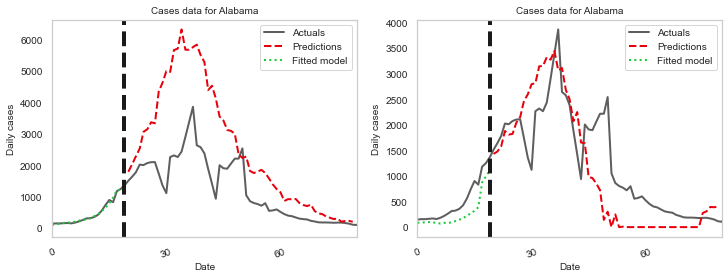

1.876536660682113e-06 0.2 True
0.04246043914029427 0.2 True
0.04703274837363565 0.2 True
0.06841737750169563 0.2 True
0.08189778689922224 0.2 True
0.0864394587684331 0.2 True
0.07948241208994224 0.2 True
0.0694896695704661 0.2 True
0.05651883066049481 0.2 True
0.07621131965522343 0.2 True
0.07826779416421854 0.2 True
0.06197725838909006 0.2 True
0.055313854043326074 0.2 True
0.05817809139902887 0.2 True
0.053743382399971805 0.2 True
0.05802718535125451 0.2 True
0.04336991924472358 0.2 True
0.03252544982447334 0.2 True
0.03790762781167065 0.2 True
0.04537054027571958 0.2 True
0.04061473925616801 0.2 True
0.030853837379825316 0.2 True
0.03279199646498972 0.2 True
0.027714775327107675 0.2 True
0.025712509189574673 0.2 True
0.07065324349902163 0.2 True
0.05145310009994338 0.2 True
0.06306334744516774 0.2 True
0.0818332465130243 0.2 True
0.056119387889416825 0.2 True
0.06481640077801815 0.2 True
0.060878742534022104 0.2 True
0.04755039104563127 0.2 True
0.08292658215338027 0.2 True
0.035707

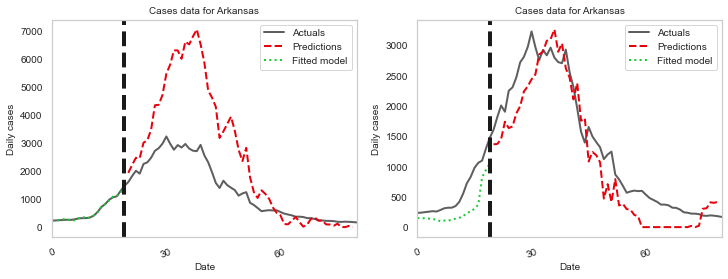

2.463422366955365e-06 0.25 True
0.04016217147327562 0.25 True
0.04701883467940077 0.25 True
0.06809245793821336 0.25 True
0.07317330474615395 0.25 True
0.08367430317505405 0.25 True
0.07790986648077032 0.25 True
0.0687128779323342 0.25 True
0.05573782347165097 0.25 True
0.06784156118475151 0.25 True
0.06442881986913758 0.25 True
0.05481348594241431 0.25 True
0.0500561203345051 0.25 True
0.05164661105547668 0.25 True
0.047491539723832646 0.25 True
0.053767324053850415 0.25 True
0.03927859160384379 0.25 True
0.029664843020336493 0.25 True
0.03690623108611854 0.25 True
0.04186234236438533 0.25 True
0.03538990866861671 0.25 True
0.025461302823928066 0.25 True
0.02629666172091152 0.25 True
0.02342612203556193 0.25 True
0.02132870283444075 0.25 True
0.04804848701220971 0.25 True
0.05034739796371436 0.25 True
0.05644080672599685 0.25 True
0.07426131926151978 0.25 True
0.047739427908640546 0.25 True
0.05655813109613733 0.25 True
0.05557108229696575 0.25 True
0.04727898366858264 0.25 True
0.063

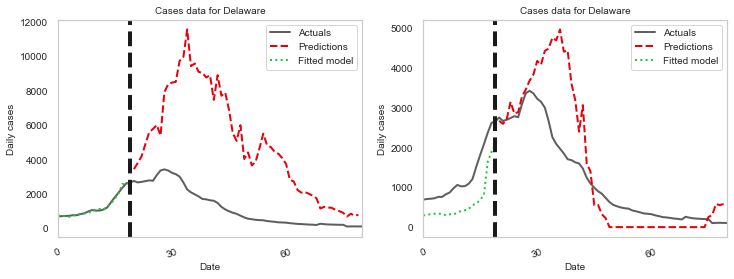

5.645531996691446e-06 0.2 True
0.04246043914065314 0.2 True
0.047032748374492034 0.2 True
0.06841737750271494 0.2 True
0.0818977869023226 0.2 True
0.08643945876937131 0.2 True
0.07948241209057198 0.2 True
0.06948966957091571 0.2 True
0.056518830659996785 0.2 True
0.07621131965385679 0.2 True
0.07826779416197135 0.2 True
0.061977258387671805 0.2 True
0.05531385404201641 0.2 True
0.05817809139750804 0.2 True
0.053743382398668736 0.2 True
0.058027185351158576 0.2 True
0.04336991924422252 0.2 True
0.03252544982396566 0.2 True
0.03790762781163559 0.2 True
0.045370540275617176 0.2 True
0.04061473925562493 0.2 True
0.030853837379302553 0.2 True
0.03279199646442388 0.2 True
0.027714775327258585 0.2 True
0.025712509189258097 0.2 True
0.07065324349944267 0.2 True
0.05145310009976736 0.2 True
0.06306334744526716 0.2 True
0.08183324651321928 0.2 True
0.056119387889682765 0.2 True
0.06481640077787666 0.2 True
0.06087874253416266 0.2 True
0.04755039104520961 0.2 True
0.08292658215736866 0.2 True
0.0

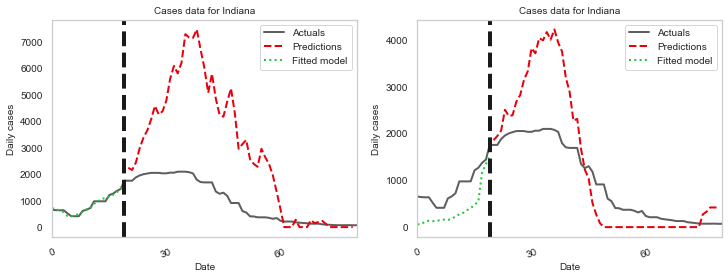

3.0993152523169385e-06 0.25 True
0.04016217147405052 0.25 True
0.047018834680200634 0.25 True
0.06809245793943881 0.25 True
0.07317330475009694 0.25 True
0.0836743031773638 0.25 True
0.07790986648254038 0.25 True
0.06871287793422377 0.25 True
0.05573782347292349 0.25 True
0.0678415611856404 0.25 True
0.06442881986946435 0.25 True
0.05481348594229087 0.25 True
0.050056120334249374 0.25 True
0.051646611055488366 0.25 True
0.04749153972385836 0.25 True
0.05376732405398409 0.25 True
0.03927859160408652 0.25 True
0.029664843020505902 0.25 True
0.036906231086073014 0.25 True
0.04186234236432275 0.25 True
0.03538990866862522 0.25 True
0.02546130282395291 0.25 True
0.02629666172089292 0.25 True
0.02342612203570807 0.25 True
0.021328702834415524 0.25 True
0.048048487011181945 0.25 True
0.050347397963214975 0.25 True
0.056440806725371134 0.25 True
0.07426131926134416 0.25 True
0.04773942790827397 0.25 True
0.056558131095061255 0.25 True
0.05557108229618343 0.25 True
0.04727898367002574 0.25 True

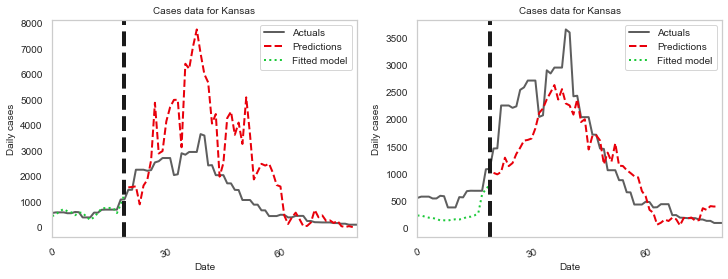

2.331267808992122e-06 0.2 True
0.042460439137483104 0.2 True
0.0470327483721445 0.2 True
0.06841737749973405 0.2 True
0.08189778689742622 0.2 True
0.08643945876614662 0.2 True
0.07948241208749299 0.2 True
0.06948966956766152 0.2 True
0.0565188306576208 0.2 True
0.07621131965238626 0.2 True
0.07826779416107468 0.2 True
0.06197725838681024 0.2 True
0.055313854041557406 0.2 True
0.05817809139676286 0.2 True
0.05374338239821643 0.2 True
0.05802718535021269 0.2 True
0.043369919242974536 0.2 True
0.03252544982300891 0.2 True
0.03790762781119312 0.2 True
0.04537054027480133 0.2 True
0.040614739255530864 0.2 True
0.03085383737932372 0.2 True
0.032791996464492344 0.2 True
0.027714775327222715 0.2 True
0.025712509189190456 0.2 True
0.07065324349934508 0.2 True
0.051453100098816366 0.2 True
0.06306334744517109 0.2 True
0.08183324651341602 0.2 True
0.05611938788945435 0.2 True
0.06481640077680333 0.2 True
0.060878742533789644 0.2 True
0.04755039104452343 0.2 True
0.08292658215716738 0.2 True
0.035

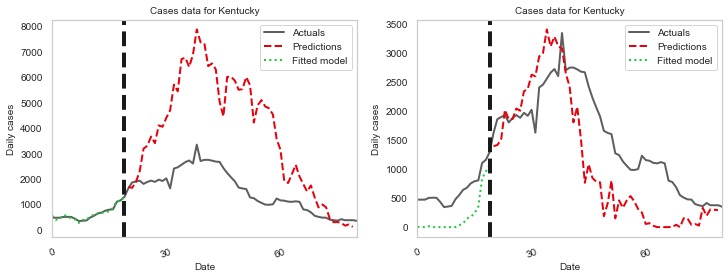

1.6613751658620552e-06 0.30000000000000004 True
0.04006496658177239 0.30000000000000004 True
0.04648953475954085 0.30000000000000004 True
0.0663148613804802 0.30000000000000004 True
0.07045319478643743 0.30000000000000004 True
0.07108722990438056 0.30000000000000004 True
0.07058303350843352 0.30000000000000004 True
0.06514607787410229 0.30000000000000004 True
0.05556345481712345 0.30000000000000004 True
0.06177665827592795 0.30000000000000004 True
0.056516151090533845 0.30000000000000004 True
0.04727990454603619 0.30000000000000004 True
0.04776591249895074 0.30000000000000004 True
0.04879205413430968 0.30000000000000004 True
0.04420490784047582 0.30000000000000004 True
0.04584148088149272 0.30000000000000004 True
0.03787253475069889 0.30000000000000004 True
0.02827193530853734 0.30000000000000004 True
0.03570409263432916 0.30000000000000004 True
0.04105948400669771 0.30000000000000004 True
0.034134423080101936 0.30000000000000004 True
0.024220506944629145 0.30000000000000004 True
0.026

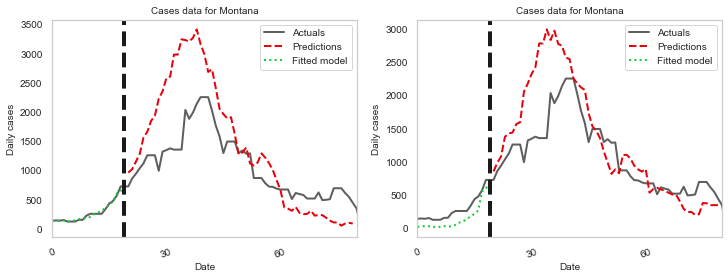

1.2653093418973756e-07 0.25 True
0.04016217146986289 0.25 True
0.04701883467821098 0.25 True
0.06809245793782004 0.25 True
0.07317330474543418 0.25 True
0.08367430317382864 0.25 True
0.07790986648078856 0.25 True
0.06871287793176016 0.25 True
0.05573782347106947 0.25 True
0.06784156118402518 0.25 True
0.06442881986892504 0.25 True
0.054813485942642855 0.25 True
0.050056120333769605 0.25 True
0.051646611055099476 0.25 True
0.047491539723894395 0.25 True
0.05376732405404751 0.25 True
0.03927859160339826 0.25 True
0.029664843019404113 0.25 True
0.03690623108590216 0.25 True
0.04186234236440841 0.25 True
0.03538990866861511 0.25 True
0.02546130282393088 0.25 True
0.026296661720837087 0.25 True
0.02342612203564082 0.25 True
0.021328702834283522 0.25 True
0.04804848701165487 0.25 True
0.05034739796310489 0.25 True
0.056440806725756326 0.25 True
0.07426131926108845 0.25 True
0.047739427910053214 0.25 True
0.056558131097353956 0.25 True
0.05557108229811893 0.25 True
0.04727898367251726 0.25 Tr

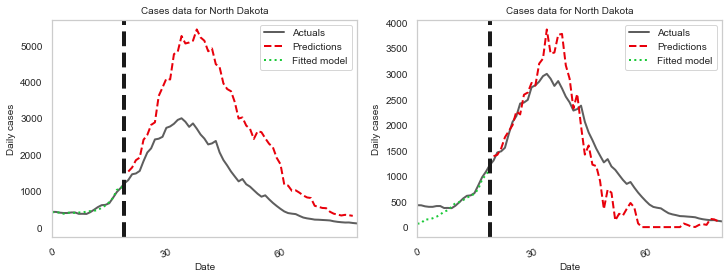

1.1076067794645062e-06 0.25 True
0.05826315061232396 0.25 True
0.07312992801878761 0.25 True
0.0910151963482144 0.25 True
0.10478263582839491 0.25 True
0.08873344730943164 0.25 True
0.07656213609012823 0.25 True
0.0639301267004677 0.25 True
0.07038999806329385 0.25 True
0.06747058915356453 0.25 True
0.0649269076896429 0.25 True
0.054185695868338664 0.25 True
0.0637594932296542 0.25 True
0.05698378110969068 0.25 True
0.04909434569803923 0.25 True
0.04249058780075362 0.25 True
0.03873660537669072 0.25 True
0.031142497438706743 0.25 True
0.029777005735300486 0.25 True
0.03373641902222239 0.25 True
0.030028382637054332 0.25 True
0.021520700369988058 0.25 True
0.03076931493507416 0.25 True
0.020813103686590905 0.25 True
0.0200869240238094 0.25 True
0.04121754788955089 0.25 True
0.05126703147168247 0.25 True
0.056132113347077274 0.25 True
0.07337789779898186 0.25 True
0.05069172133311724 0.25 True
0.05834890156053644 0.25 True
0.057879450089171745 0.25 True
0.05303428261744525 0.25 True
0.06

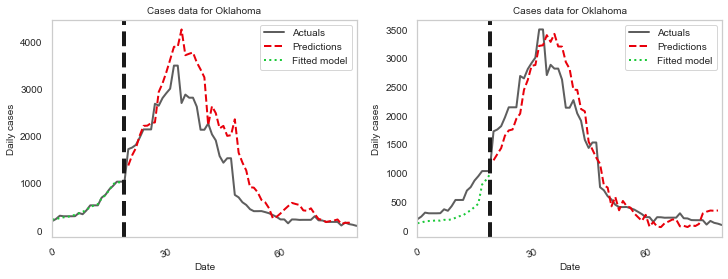

1.3461477436311177e-06 0.25 True
0.040162171481618734 0.25 True
0.04701883469049216 0.25 True
0.06809245795373213 0.25 True
0.07317330475649399 0.25 True
0.08367430320090286 0.25 True
0.07790986650275966 0.25 True
0.0687128779536672 0.25 True
0.0557378234865116 0.25 True
0.06784156120596219 0.25 True
0.06442881989096384 0.25 True
0.05481348596239111 0.25 True
0.05005612034576697 0.25 True
0.05164661107001445 0.25 True
0.047491539737292365 0.25 True
0.05376732406911083 0.25 True
0.039278591613420615 0.25 True
0.02966484302806255 0.25 True
0.036906231094854414 0.25 True
0.04186234237379774 0.25 True
0.03538990867462964 0.25 True
0.02546130282704711 0.25 True
0.026296661722630118 0.25 True
0.02342612203696869 0.25 True
0.021328702834779268 0.25 True
0.04804848701281428 0.25 True
0.050347397963293565 0.25 True
0.05644080672504038 0.25 True
0.07426131925951618 0.25 True
0.04773942790723857 0.25 True
0.05655813109485442 0.25 True
0.055571082294659416 0.25 True
0.047278983666906735 0.25 True


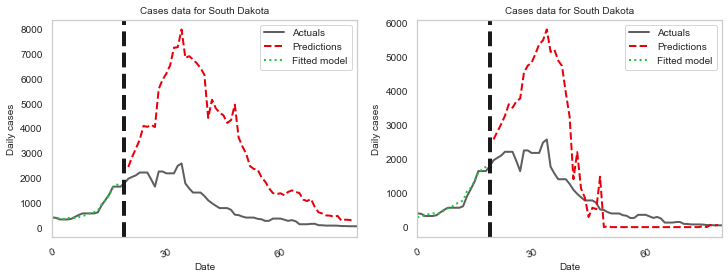

1.3271720640424974e-06 0.35000000000000003 True
0.02729399099337822 0.35000000000000003 True
0.02835903462709513 0.35000000000000003 True
0.04570875205050083 0.35000000000000003 True
0.05878744452555695 0.35000000000000003 True
0.04609267497986449 0.35000000000000003 True
0.04737507746831129 0.35000000000000003 True
0.04114278435915609 0.35000000000000003 True
0.04764440199195813 0.35000000000000003 True
0.04414276122307102 0.35000000000000003 True
0.04418432365629403 0.35000000000000003 True
0.039144587262504936 0.35000000000000003 True
0.04125618715379314 0.35000000000000003 True
0.03955141728874495 0.35000000000000003 True
0.03408537379285011 0.35000000000000003 True
0.03322011502215475 0.35000000000000003 True
0.030394877020749063 0.35000000000000003 True
0.025304360472265613 0.35000000000000003 True
0.023639287201924666 0.35000000000000003 True
0.024126392409405156 0.35000000000000003 True
0.025239897631135 0.35000000000000003 True
0.020397099910473428 0.35000000000000003 True
0.0

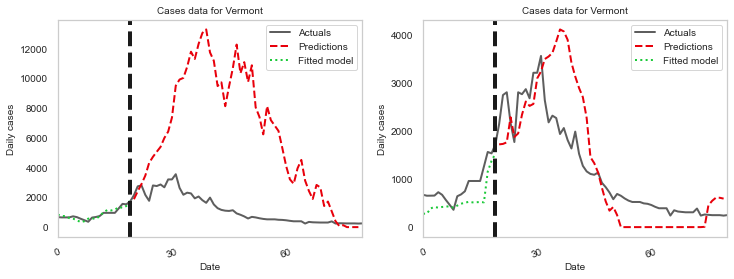

1.6453970186438348e-06 0.25 True
0.06543022534784249 0.25 True
0.07914660497016153 0.25 True
0.10187714120880648 0.25 True
0.12125045378494032 0.25 True
0.09826967938750102 0.25 True
0.08567001994372678 0.25 True
0.08187284834848318 0.25 True
0.09042360230277577 0.25 True
0.07933600664250014 0.25 True
0.08040115388368324 0.25 True
0.07618969727794876 0.25 True
0.0747681928760004 0.25 True
0.07136903762025147 0.25 True
0.06368880901040282 0.25 True
0.05149812901293087 0.25 True
0.04765943444246275 0.25 True
0.035017205930382385 0.25 True
0.04281239684790573 0.25 True
0.04974193919467559 0.25 True
0.03930206850084361 0.25 True
0.027169976756334372 0.25 True
0.02950370662014467 0.25 True
0.024990258141157268 0.25 True
0.020790326241551218 0.25 True
0.027120123999680713 0.25 True
0.02171238098524228 0.25 True
0.024311386863972873 0.25 True
0.0339162851482635 0.25 True
0.024301496535472124 0.25 True
0.02822908230605611 0.25 True
0.029873915038377538 0.25 True
0.04824045663485613 0.25 True
0

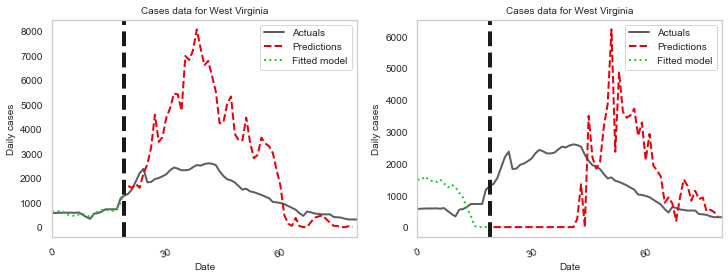

4.073566194432122e-05 0.2 True
0.0424604391505625 0.2 True
0.04703274838188368 0.2 True
0.0684173775105032 0.2 True
0.08189778691612 0.2 True
0.08643945877281112 0.2 True
0.07948241209467864 0.2 True
0.06948966957653036 0.2 True
0.056518830664054026 0.2 True
0.07621131965582287 0.2 True
0.07826779416113863 0.2 True
0.06197725838426828 0.2 True
0.05531385404072236 0.2 True
0.058178091396686164 0.2 True
0.05374338239750382 0.2 True
0.05802718535031055 0.2 True
0.043369919242334874 0.2 True
0.03252544982211074 0.2 True
0.03790762781054077 0.2 True
0.04537054027330229 0.2 True
0.04061473925360701 0.2 True
0.030853837377973325 0.2 True
0.03279199646354597 0.2 True
0.027714775327196815 0.2 True
0.025712509189242908 0.2 True
0.07065324350025022 0.2 True
0.05145310009969282 0.2 True
0.06306334744760601 0.2 True
0.08183324651769162 0.2 True
0.05611938789352094 0.2 True
0.06481640078268396 0.2 True
0.06087874253869831 0.2 True
0.04755039105165433 0.2 True
0.0829265821698743 0.2 True
0.0357073152

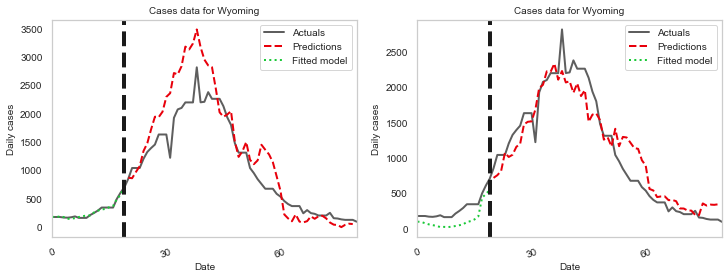

5.200338453278505e-07 0.25 True
0.040162171473558696 0.25 True
0.04701883467998933 0.25 True
0.06809245793916364 0.25 True
0.0731733047441027 0.25 True
0.08367430317594556 0.25 True
0.0779098664810796 0.25 True
0.0687128779328074 0.25 True
0.05573782347256423 0.25 True
0.06784156118617819 0.25 True
0.06442881987071612 0.25 True
0.05481348594330644 0.25 True
0.05005612033503683 0.25 True
0.05164661105627813 0.25 True
0.047491539724557684 0.25 True
0.053767324054734694 0.25 True
0.039278591604510076 0.25 True
0.02966484302104255 0.25 True
0.03690623108650141 0.25 True
0.04186234236468852 0.25 True
0.03538990866817322 0.25 True
0.02546130282333587 0.25 True
0.026296661719357364 0.25 True
0.02342612203472324 0.25 True
0.0213287028330679 0.25 True
0.04804848700688526 0.25 True
0.050347397962251614 0.25 True
0.05644080672235898 0.25 True
0.07426131925758186 0.25 True
0.04773942790546356 0.25 True
0.056558131091434455 0.25 True
0.055571082293012275 0.25 True
0.04727898366752405 0.25 True
0.06

In [37]:
# predict west/south based on North East and Midwest groups = [northeast, west, south, midwest]
#import warnings
percent_change_in_day = []
pre_R2 = {}

from syn_model import *

# RMSE
Test_err = []
Test_R2 = []

#RMSE
Test_err_2d = []
Test_R2_2d = []

FONTSIZE = 10
singVals = 4
warnings.simplefilter('ignore')

projection_period=80
training_period=20
df1 = omicron_cases_pop_adjusted_daily#  omicron_cases_pop_adjusted_daily
df2 = immune_per_million

for day in range(projection_period-training_period):
    percent_change_in_day.append([])


for state in late_omicron_states: #south+west:
    if state == "Maine":
        continue

    fig, axes = plt.subplots(1,2, figsize=(12,4)) 

    try:
        otherStates = omicron_cases_pop_adjusted.columns[(omicron_cases_pop_adjusted.iloc[training_period] < 
                                      omicron_cases_pop_adjusted[state].iloc[training_period]+.5*omicron_cases_pop_adjusted[state].iloc[training_period])&(omicron_cases_pop_adjusted.iloc[training_period]
                                                                                                         > omicron_cases_pop_adjusted[state].iloc[training_period]-0.5*omicron_cases_pop_adjusted[state].iloc[training_period])]
    except:
        continue
    otherStates = list(otherStates[otherStates.isin(early_omicron_states)]) # list(otherStates[otherStates.isin(northeast+midwest)])


    #try:
    rscModel =syn_model(state, singVals, [df1], projection_period, training_period, otherStates=otherStates, mRSC=True)

    rscModel.fit_model(filter_donor = True, filter_method = 'hbo', backward_donor_eliminate = True, singVals_estimate = True, singval_mathod ='auto')
    #print(state, 'singvals:', rscModel.kSingularValues)
    #print(rscModel.donors)
    rscModel.plot(figure=fig, axes=axes[0], title_text="Cases data", xlimit=[0,projection_period], logy=False, show_donors=False, tick_spacing=30, yaxis="Daily cases", intervention_date_x_ticks=None, fontsize = FONTSIZE)
    plt.title(state + ' with '+str(len(rscModel.donors))+' donors and singval '+str(rscModel.kSingularValues)+ ', 1D' )

    Test_err.append(np.sqrt(rscModel.test_err)) #RMSE
    Test_R2.append(1-rscModel.test_err/np.var(df1[state].iloc[training_period:projection_period]))
    
    
    # hypothesis test

    # print('1D for',rscModel.state, passed_H0(rscModel.donors, rscModel.state, rscModel.kSingularValues, alpha = 0.05, train=rscModel.train, test=rscModel.test))

    #############
    #############

    rscModel =syn_model(state, singVals, [df1, df2], projection_period, training_period, otherStates=otherStates, mRSC=True)
    rscModel.fit_model(filter_donor = True, filter_method = 'hbo', backward_donor_eliminate = True, singVals_estimate = True, singval_mathod ='auto')
    rscModel.plot(figure=fig, axes=axes[1], title_text="Cases data", xlimit=[0,projection_period], logy=False, show_donors=False, tick_spacing=30, yaxis="Daily cases", intervention_date_x_ticks=None, fontsize = FONTSIZE)

    Test_err_2d.append(np.sqrt(rscModel.test_err)) #RMSE
    Test_R2_2d.append(1-rscModel.test_err/np.var(df1[state].iloc[training_period:projection_period]))

    pre_R2[state] = 1-(mean_squared_error(rscModel.train.index[:training_period], rscModel.model_fit[:training_period])/np.var(df1[state].iloc[:training_period]))

    for day in range(projection_period-training_period):
        percent_change_in_day[day].append((df1[state].iloc[training_period+day]-rscModel.predictions[day])/df1[state].iloc[training_period+day])
    

    plt.show()
    
    print( '2D for',rscModel.state, passed_H0(rscModel.donors, rscModel.state, rscModel.kSingularValues, alpha = 0.05, train=rscModel.train, test=rscModel.test))
    


In [35]:
pre_R2

{'Alabama': -0.06003739291286503,
 'Arkansas': -0.0068080744485836675,
 'Delaware': -0.6246506214433085,
 'Indiana': -1.321219114854038,
 'Kansas': -2.1234659101776625,
 'Kentucky': -1.01691826731785,
 'Montana': -0.6287109226213594,
 'North Dakota': -3.7805035834854053,
 'Oklahoma': -0.9822314249221571,
 'South Dakota': -2.6818107111652307,
 'Vermont': -2.2316178306655527,
 'West Virginia': -25.284245175961967,
 'Wyoming': -0.602994673076094}

In [26]:
print(Test_R2, sum(Test_R2)/len(Test_R2))
print(Test_R2_2d, sum(Test_R2_2d)/len(Test_R2_2d))

[-2.0896651455680937, -2.089759811617958, -14.258469785898788, -9.032469680484443, -1.9879778032049158, -10.426312328467906, -0.7861508679605964, -1.2764119470975412, 0.7430910538225106, -10.790007025935642, -38.210869668801216, -7.733401195057478, 0.67448736914737] -7.4818397567019
[0.44402165757168965, 0.845892660290401, 0.2322111537335262, -0.18538453059751125, 0.7289911499723485, 0.07248729520594166, -0.011002409322651951, 0.7958679925952322, 0.9223575251760535, -2.2199446546652, 0.34228496710998846, -4.835726189423416, 0.8871401428936004] -0.15236947995846137


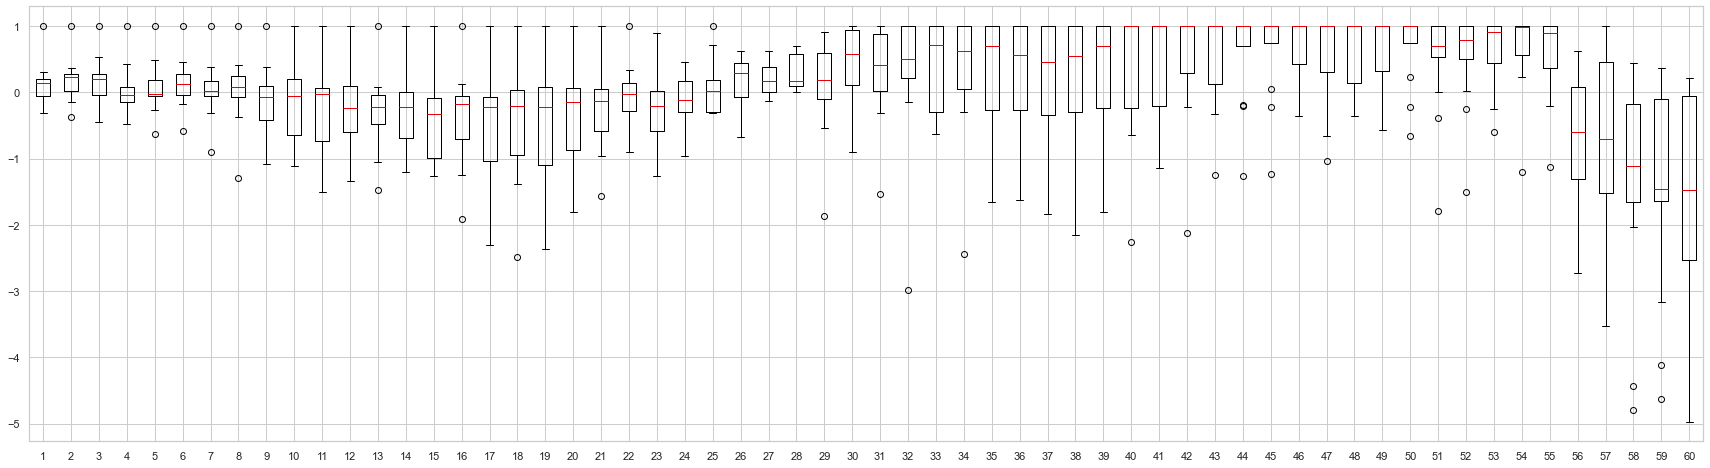

In [32]:
fig, ax = plt.subplots()

plt.rcParams['figure.figsize'] = (30.0, 8.0)

plt.boxplot(percent_change_in_day)

plt.show()

## sliding window, we do not use it in the final paper

104
103
102
101
100
99
98
97
96
95
94
93
92
91
90
89
88
87
86
85
84
83
82
81
80
79
78
77
76
75
74
73
72
71
70
69
68
67
66
65
64
63
62
61
60
59
58
57
56
55
54
53
52
51
50
49
48
47
46
45
44
43
42
41
40
39
38
37
36
35
34
33
32
31
30
29
28
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13


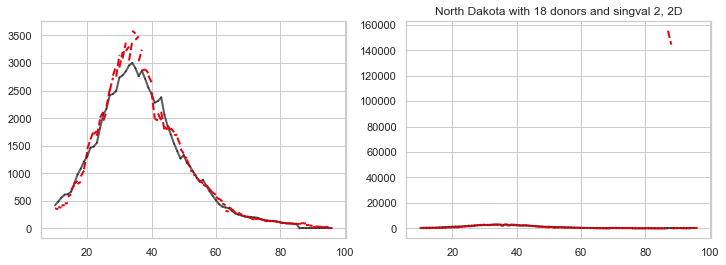

In [18]:
# predict west/south based on North East and Midwest groups = [northeast, west, south, midwest]
#import warnings
from syn_model import *

# RMSE
Test_err = []
Test_R2 = []

#RMSE
Test_err_2d = []
Test_R2_2d = []

FONTSIZE = 10
singVals = 4
warnings.simplefilter('ignore')

projection_period=12
training_period=10
expand_training = False
for state in ['North Dakota']:#late_omicron_states: #south+west:
    df1 = omicron_cases_pop_adjusted_daily#  omicron_cases_pop_adjusted_daily
    df2 = immune_per_million

    fig, axes = plt.subplots(1,2, figsize=(12,4)) 

    try:
        otherStates = omicron_cases_pop_adjusted.columns[(omicron_cases_pop_adjusted.iloc[training_period] < 
                                      omicron_cases_pop_adjusted[state].iloc[training_period]+.5*omicron_cases_pop_adjusted[state].iloc[training_period])&(omicron_cases_pop_adjusted.iloc[training_period]
                                                                                                         > omicron_cases_pop_adjusted[state].iloc[training_period]-0.5*omicron_cases_pop_adjusted[state].iloc[training_period])]
    except:
        continue
    otherStates = list(otherStates[otherStates.isin(early_omicron_states)]) # list(otherStates[otherStates.isin(northeast+midwest)])

    while len(df1) > projection_period:
        print(len(df1))
        try:
            rscModel =syn_model(state, singVals, [df1], projection_period, training_period, otherStates=otherStates, mRSC=True)

            rscModel.fit_model(filter_donor = True, filter_method = 'hbo', backward_donor_eliminate = True, singVals_estimate = True, singval_mathod ='auto')
        except:
            if expand_training:
                training_period,  projection_period = projection_period, projection_period + training_period
            else:    
                df1 = df1.iloc[projection_period - training_period-1:]
                df2 = df2.iloc[projection_period - training_period-1:]
            continue
        #print(state, 'singvals:', rscModel.kSingularValues)
        #print(rscModel.donors)
        #rscModel.plot(figure=fig, axes=axes[0], title_text="Cases data", xlimit=[0,projection_period], logy=False, show_donors=False, tick_spacing=30, yaxis="Daily cases", intervention_date_x_ticks=None, fontsize = FONTSIZE)
        axes[0].plot(rscModel.actual.index[rscModel.low_thresh:rscModel.thresh], rscModel.actual[rscModel.low_thresh:rscModel.thresh], label='Actuals', color='k', linestyle='-', alpha = 0.7)
        axes[0].plot(rscModel.test.index, rscModel.predictions, label='Prediction', color='r', linestyle='--')
        #axes[0].plot(rscModel.train.index[:rscModel.low_thresh], rscModel.model_fit[:rscModel.low_thresh], label = 'Fitted model', color='g', linestyle=':')
        #axes[0].legend()
        plt.title(state + ' with '+str(len(rscModel.donors))+' donors and singval '+str(rscModel.kSingularValues)+ ', 1D' )

        Test_err.append(np.sqrt(rscModel.test_err)) #RMSE
        Test_R2.append(1-rscModel.test_err/np.var(df1[state].iloc[training_period:projection_period]))

        #############
        #############
        try:
            rscModel =syn_model(state, singVals, [df1, df2], projection_period, training_period, otherStates=otherStates, mRSC=True)
            rscModel.fit_model(filter_donor = True, filter_method = 'hbo', backward_donor_eliminate = True, singVals_estimate = True, singval_mathod ='auto')
        except:
            if expand_training:
                training_period,  projection_period = projection_period, projection_period + training_period
            else:    
                df1 = df1.iloc[projection_period - training_period-1:]
                df2 = df2.iloc[projection_period - training_period-1:]
            continue
        #rscModel.plot(figure=fig, axes=axes[1], title_text="Cases data", xlimit=[0,projection_period], logy=False, show_donors=False, tick_spacing=30, yaxis="Daily cases", intervention_date_x_ticks=None, fontsize = FONTSIZE)
        axes[1].plot(rscModel.actual.index[rscModel.low_thresh:rscModel.thresh], rscModel.actual[rscModel.low_thresh:rscModel.thresh], label='Actuals', color='k', linestyle='-', alpha = 0.7)
        axes[1].plot(rscModel.test.index, rscModel.predictions, label='Prediction', color='r', linestyle='--')
        #axes[1].plot(rscModel.train.index[:rscModel.low_thresh], rscModel.model_fit[:rscModel.low_thresh], label = 'Fitted model', color='g', linestyle=':')
        #axes[1].legend()
        plt.title(state + ' with '+str(len(rscModel.donors))+' donors and singval '+str(rscModel.kSingularValues) + ', 2D')

        Test_err_2d.append(np.sqrt(rscModel.test_err)) #RMSE
        Test_R2_2d.append(1-rscModel.test_err/np.var(df1[state].iloc[training_period:projection_period]))

        if expand_training:
            training_period,  projection_period = projection_period, projection_period + training_period
        else:    
            df1 = df1.iloc[projection_period - training_period-1:]
            df2 = df2.iloc[projection_period - training_period-1:]

    plt.show()
    break
        


In [212]:
print(np.mean(Test_err), np.mean(Test_err_2d))
print(np.mean(Test_R2), np.mean(Test_R2_2d))

63.178175581376074 812.4841906024831
0.0797167370955154 -247.5695588140572


In [180]:
print(np.mean(Test_err), np.mean(Test_err_2d))
print(np.mean(Test_R2), np.mean(Test_R2_2d))

1496.028956500018 744.8135412409049
-3.0524528992329754 -0.21696491906125648


In [ ]:
sorted_idx = np.argsort(Test_err_2d)
Test_err_2d = np.array(Test_err_2d)[sorted_idx] #RMSE
Test_R2_2d = np.array(Test_R2_2d)[sorted_idx]

sorted_idx = np.argsort(Test_err)
Test_err = np.array(Test_err)[sorted_idx] #RMSE
Test_R2 = np.array(Test_R2)[sorted_idx]

plt.plot(Test_err,Test_R2, label='1D')
plt.plot(Test_err_2d,Test_R2_2d, label = '2D')
plt.legend()
plt.show()


# Global vaccination data

In [241]:
_update_vaccination_data(local_path = _vaccine_global_local_path, web_path = _vaccine_global_web_path)
vaccine, full_vaccine,regions = _import_vaccination_data(local_path = _vaccine_global_local_path)
vaccine_pop_adjusted, full_vaccine_pop_adjusted = create_population_adjusted_data(vaccine, all_population, fast=True), \
                                    create_population_adjusted_data(full_vaccine, all_population, show_exception = True, fast=True)


These countries/region do not have population data:  {'Wales', 'Falkland Islands', 'Macao', 'Faeroe Islands', 'Palestine', 'Low income', 'Africa', 'Lower middle income', 'Asia', 'Europe', 'United States', 'Anguilla', 'Niue', 'World', 'Eswatini', 'Upper middle income', 'England', 'Tokelau', 'Kyrgyzstan', 'North Macedonia', 'Syria', 'Guernsey', 'South Korea', 'Cook Islands', 'Oceania', 'Congo', 'Hong Kong', 'Saint Lucia', 'Pitcairn', 'Taiwan', 'Bahamas', 'Northern Ireland', 'European Union', 'British Virgin Islands', 'Slovakia', 'Timor', "Cote d'Ivoire", 'Bonaire Sint Eustatius and Saba', 'South America', 'Wallis and Futuna', 'North America', 'Montserrat', 'Saint Kitts and Nevis', 'High income', 'Gambia', 'Scotland', 'Saint Vincent and the Grenadines', 'Saint Helena', 'Jersey', 'Northern Cyprus'}


/Users/niloofarbayat/Documents/COVID19-synthetic-control-analysis/synthetic_control_analysis/filter_data.py:49: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  cap = df.columns & pop
/Users/niloofarbayat/Documents/COVID19-synthetic-control-analysis/synthetic_control_analysis/filter_data.py:55: FutureWarning: Index.__and__ operating as a set operation is deprecated, in the future this will be a logical operation matching Series.__and__.  Use index.intersection(other) instead
  cap2 = df2.columns & pop


In [243]:
df1, df2 = full_vaccine_pop_adjusted, all_cases_data_pop_daily
df1 = df1.reindex(df2.index, fill_value=0)


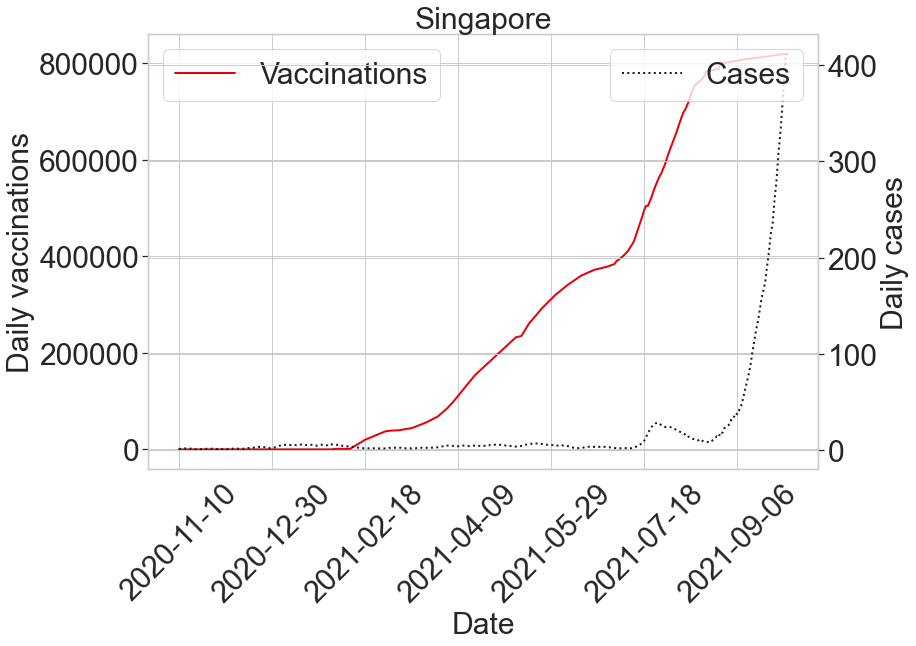

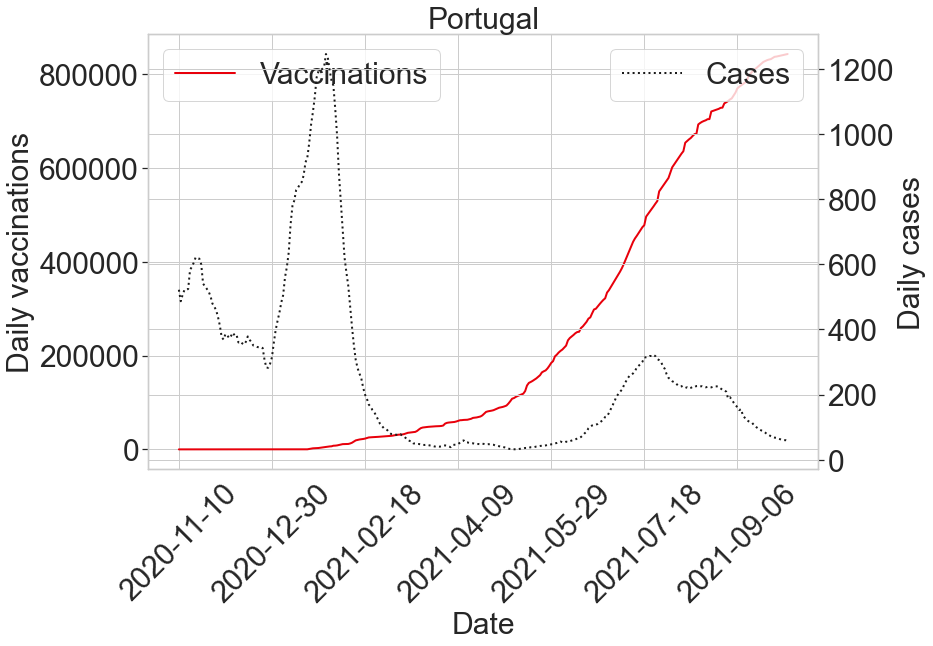

In [245]:
for target in ['Singapore', 'Portugal']:
    fig, ax = plt.subplots()

    plt.rcParams['figure.figsize'] = (12.0, 8.0)




    FONTSIZE = 30

    df1[target].loc['2020-11-1':].plot(ax = ax, color='r', label='Vaccinations')
    #plt.legend()
    plt.ylabel('Daily vaccinations', fontsize = FONTSIZE ), plt.xlabel('Date',fontsize = FONTSIZE)
    plt.yticks(fontsize = FONTSIZE)
    plt.legend(fontsize = FONTSIZE , loc = 'upper left')
    plt.xticks(fontsize = FONTSIZE)
    plt.xticks(rotation=45)
    #ax.axes.xaxis.set_ticklabels([])


    ax2 = ax.twinx()
    ax2.set_ylabel('Cases')
    df2[target].loc['2020-11-1':].plot(ax = ax2, secondary_y=True, color='k',linestyle=":", label='Cases')
    #plt.legend()
    plt.ylabel('Daily cases', fontsize = FONTSIZE ), plt.xlabel('Date',fontsize = FONTSIZE)

    plt.legend(fontsize = FONTSIZE , loc = 'upper right')
    plt.yticks(fontsize = FONTSIZE)
    #plt.xticks(fontsize = FONTSIZE)
    #ax2.axes.xaxis.set_ticklabels([])

    #plt.savefig('../Figures/COVID/'+target+'_deaths_cases.pdf', bbox_inches='tight')
    plt.title(target, fontsize = FONTSIZE)

    plt.show()

In [246]:
donors  = ['Italy', 'United Kingdom', 'France', 'Spain', 'Germany', 'Netherlands', 'Belgium', 'Switzerland']

total = full_vaccine_pop_adjusted
total = total[set(global_cases.columns).intersection(set(total.columns))]
vaccine_intervention = pd.DataFrame(total.apply(pd.Series.first_valid_index))
vaccine_intervention = vaccine_intervention.reset_index()
vaccine_intervention.columns = ["name", "date"]


case_vaccine_adjusted, case_vaccine_adjusted_daily, vaccine_date_case= create_intervention_adjusted_data(all_cases_data_pop, vaccine_intervention, 7, ignore_nan=False)
deaths_vaccine_adjusted, deaths_vaccine_adjusted_daily, _ = create_intervention_adjusted_data(all_death_data_pop, vaccine_intervention, 7)
vaccine_adjusted, vaccine_adjusted_daily, vaccine_date = create_intervention_adjusted_data(df1, vaccine_intervention, 7, ignore_nan=False)



In [247]:
immune_per_million = case_vaccine_adjusted.add(vaccine_adjusted)

In [248]:
immune_per_million

,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,...,United Arab Emirates,United Kingdom,Uruguay,Uzbekistan,Vanuatu,Venezuela,Vietnam,Yemen,Zambia,Zimbabwe
0,3139.649373,13503.892298,20394.126341,112979.438934,2215.892319,29656.494369,33096.992164,48961.266019,18679.317236,33155.043823,...,45883.007281,31233.346954,6781.765118,6075.496414,434.532896,8181.699914,117.312478,397.060027,1157.924364,667.125945
1,3146.382332,13747.907269,20417.622227,113717.310176,2218.609931,29678.276591,33270.496609,49380.126400,18679.990037,33616.309577,...,46023.337650,31481.588263,6840.339147,6077.381428,434.532896,8196.037024,117.388810,397.060027,1160.083290,667.125945
2,3154.468031,14018.573520,20438.874407,114597.079733,2220.288455,29678.276591,33446.212182,49803.294682,18680.410538,34077.226943,...,46167.162628,31709.994831,6907.364154,6080.448569,434.532896,8211.499243,117.421525,397.060027,1161.933798,686.032867
3,3163.014892,14295.816060,20459.118180,115320.761143,2225.563818,29678.276591,33605.113970,50195.644912,18680.704889,34520.260390,...,46310.332367,31960.201192,6987.794163,6090.672375,434.532896,8222.075272,117.421525,397.060027,1169.767614,693.916092
4,3167.011626,14588.634025,20478.580437,116030.252721,2227.282308,29678.276591,33724.906433,50615.499425,18681.083340,34920.209850,...,46442.909074,32198.755410,7055.984823,6090.672375,434.532896,8231.719068,117.465143,397.060027,1172.296641,698.402480
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
302,NaN,331583.463330,NaN,NaN,44535.824791,496228.952929,624963.104682,135794.734554,475492.226644,714987.467321,...,980060.091976,808107.088323,861876.904202,147976.006006,75290.246383,205363.436191,112051.070948,NaN,37607.868408,152499.197097
303,NaN,334009.422093,NaN,NaN,45216.016930,498927.225598,629845.966148,136716.006476,483303.406994,715994.308733,...,981157.835846,809184.811771,862393.871000,150593.971150,77924.703276,206011.721367,115689.895075,NaN,38152.966299,154003.354921
304,NaN,336197.596055,NaN,NaN,45955.876623,502300.747130,635574.837410,137608.117231,491185.357625,717315.860667,...,984465.919541,810242.224566,862894.518666,151783.031678,80559.160169,206618.345347,119124.125718,NaN,38588.329082,155175.327735
305,NaN,338072.184820,NaN,NaN,46657.130249,505260.406456,641436.007827,138572.468148,496246.589055,718040.275515,...,986111.825504,811221.373033,862975.531501,152970.750331,83193.617063,207269.973706,123065.718105,NaN,39202.080810,156022.614217


/Users/niloofarbayat/anaconda3/envs/p38/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(
/Users/niloofarbayat/anaconda3/envs/p38/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)
/Users/niloofarbayat/anaconda3/envs/p38/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(
/Users/niloofarbayat/anaconda3/envs/p38/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  wa

6
['Italy', 'United Kingdom', 'Germany', 'Netherlands', 'Switzerland']
target rank estimation:  6


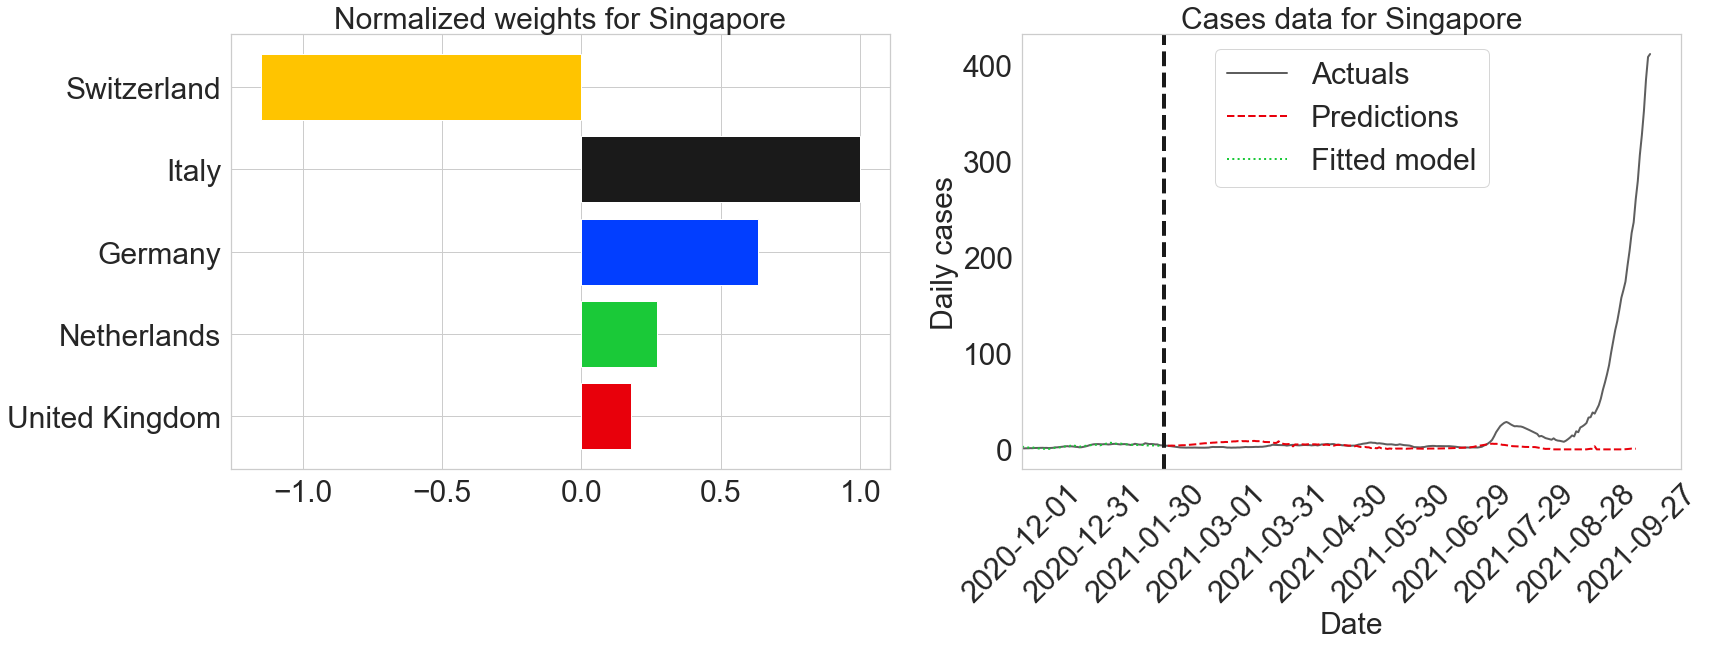

In [269]:
target = 'Singapore'# 'Italy', 'Spain', 'United Kingdom', 'France']
singVals = 2
lambdas = [1]
projection_period=300
training_period=70
rscModel = syn_model(target, singVals, [case_vaccine_adjusted_daily, case_vaccine_adjusted, immune_per_million], projection_period, training_period, otherStates=donors+['Portugal'])

# to ensure there aren't too few donors
fig, axes = plt.subplots(1, 2, figsize = (26, 8))
try:
    rscModel.fit_model(filter_donor = True, filter_method = 'combine', singVals_estimate = True, singval_mathod = "auto")
    print(rscModel.donors)
    print('target rank estimation: ', rscModel.kSingularValues)
except Exception as e:
    print(e)
    rscModel.fit_model(filter_donor = True, filter_method = 'combine')
    print('target model rank estimation failed, rank 2 ued by default')


rscModel.plot(figure=fig, axes=axes, title_text="Cases data", ylimit=[], xlimit=[], logy=False, show_donors=True, tick_spacing=30, xaxis="Date", yaxis="Daily cases", intervention_date_x_ticks=vaccine_date_case, fontsize = FONTSIZE)



/Users/niloofarbayat/anaconda3/envs/p38/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(
/Users/niloofarbayat/anaconda3/envs/p38/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1434: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)
/Users/niloofarbayat/anaconda3/envs/p38/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(
/Users/niloofarbayat/anaconda3/envs/p38/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  wa

5
target rank estimation:  5


/Users/niloofarbayat/Documents/COVID19-synthetic-control-analysis/synthetic_control_analysis/syn_model.py:423: UserWarning: FixedFormatter should only be used together with FixedLocator
/Users/niloofarbayat/Documents/COVID19-synthetic-control-analysis/synthetic_control_analysis/syn_model.py:431: UserWarning: FixedFormatter should only be used together with FixedLocator


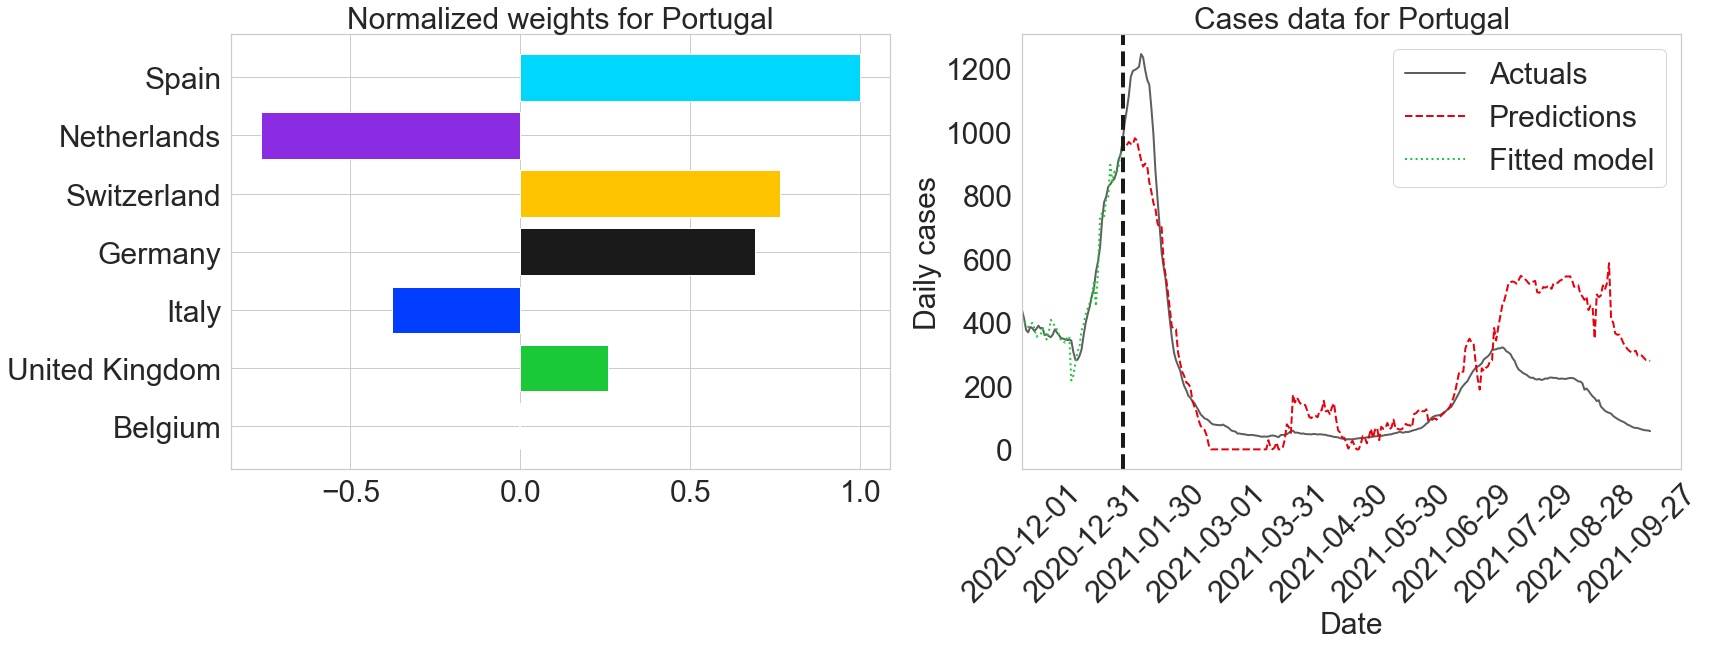

In [257]:
target = 'Portugal'# 'Italy', 'Spain', 'United Kingdom', 'France']
singVals = 2
lambdas = [1]
projection_period=400
training_period=50
rscModel = syn_model(target, singVals, [case_vaccine_adjusted_daily, case_vaccine_adjusted, immune_per_million], projection_period, training_period, otherStates=donors+['Singapore'])

# to ensure there aren't too few donors
fig, axes = plt.subplots(1, 2, figsize = (26, 8))

try:
    rscModel.fit_model(filter_donor = True, filter_method = 'combine', singVals_estimate = True, singval_mathod = "auto")
    print('target rank estimation: ', rscModel.kSingularValues)
except Exception as e:
    print(e)
    rscModel.fit_model(filter_donor = True, filter_method = 'combine')
    print('target model rank estimation failed, rank 2 ued by default')


rscModel.plot(figure=fig, axes=axes, title_text="Cases data", ylimit=[], xlimit=[], logy=False, show_donors=True, tick_spacing=30, xaxis="Date", yaxis="Daily cases", intervention_date_x_ticks=vaccine_date_case, fontsize = FONTSIZE)



# US States

In [ ]:
_update_vaccination_data()
vaccine, full_vaccine,_ = _import_vaccination_data()

vaccine_pop_adjusted, full_vaccine_pop_adjusted = create_population_adjusted_data(vaccine, all_population, fast=True), \
                                    create_population_adjusted_data(full_vaccine, all_population, show_exception = True, fast=True)


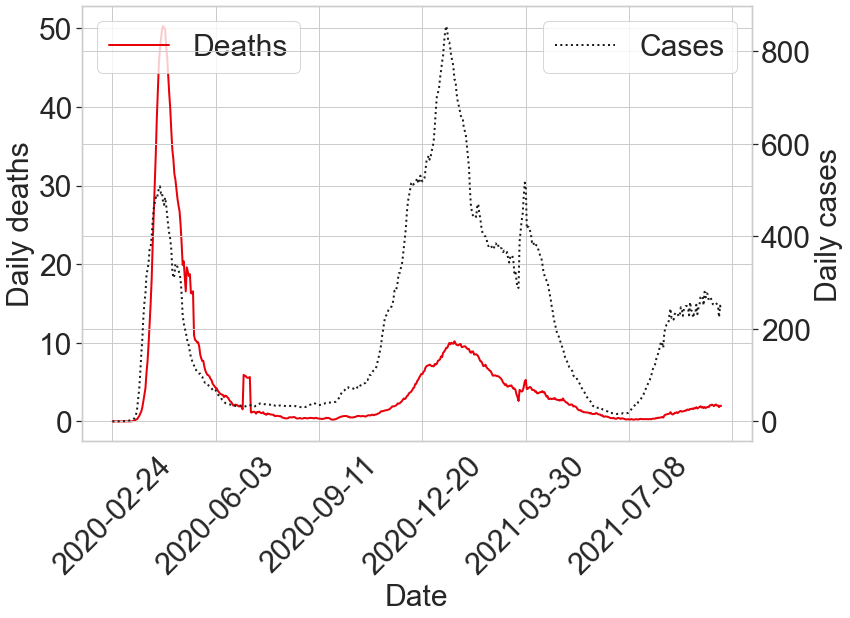

In [27]:
fig, ax = plt.subplots()

plt.rcParams['figure.figsize'] = (12.0, 8.0)


target ='New York'

FONTSIZE = 30

all_death_data_pop_daily[target].iloc[25:].plot(ax = ax, color='r', label='Deaths')
#plt.legend()
plt.ylabel('Daily deaths', fontsize = FONTSIZE ), plt.xlabel('Date',fontsize = FONTSIZE)
plt.yticks(fontsize = FONTSIZE)
plt.legend(fontsize = FONTSIZE , loc = 'upper left')
plt.xticks(fontsize = FONTSIZE)
plt.xticks(rotation=45)
#ax.axes.xaxis.set_ticklabels([])


ax2 = ax.twinx()
ax2.set_ylabel('Cases')
all_cases_data_pop_daily[target].iloc[25:].plot(ax = ax2, secondary_y=True, color='k',linestyle=":", label='Cases')
#plt.legend()
plt.ylabel('Daily cases', fontsize = FONTSIZE ), plt.xlabel('Date',fontsize = FONTSIZE)

plt.legend(fontsize = FONTSIZE , loc = 'upper right')
plt.yticks(fontsize = FONTSIZE)
#plt.xticks(fontsize = FONTSIZE)
#ax2.axes.xaxis.set_ticklabels([])

#plt.savefig('../Figures/COVID/'+target+'_deaths_cases.pdf', bbox_inches='tight')

plt.show()

In [14]:
total = full_vaccine_pop_adjusted
total = total[set(uscases.columns).intersection(set(total.columns))]
vaccine_intervention = pd.DataFrame(total.apply(pd.Series.first_valid_index))
vaccine_intervention = vaccine_intervention.reset_index()
vaccine_intervention.columns = ["name", "date"]
total = total.fillna(0)
donors = full_vaccine_pop_adjusted.tail(1)[full_vaccine_pop_adjusted.tail(1)>630000].dropna(axis = 1).columns.tolist()


In [28]:
df1, df2 = full_vaccine_pop_adjusted, all_cases_data_pop_daily
df1 = df1.reindex(df2.index, fill_value=0)

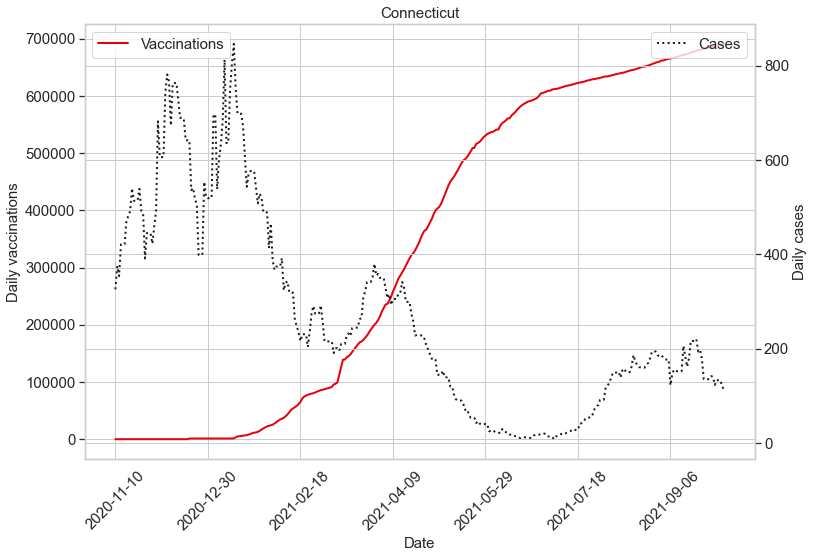

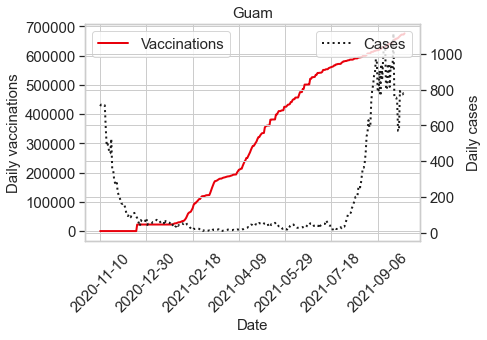

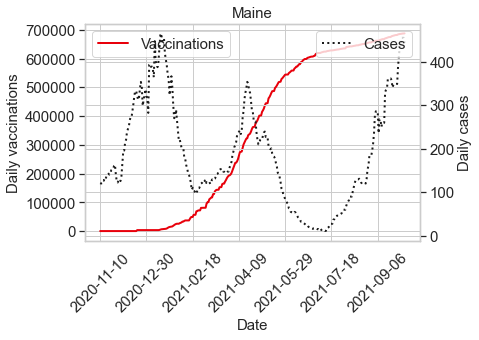

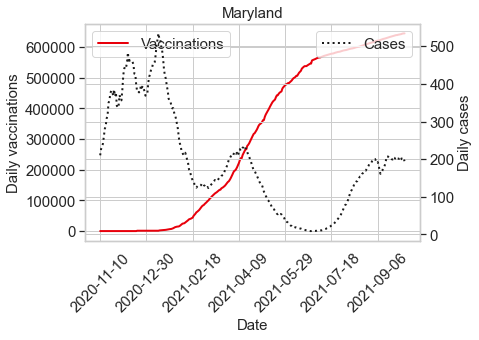

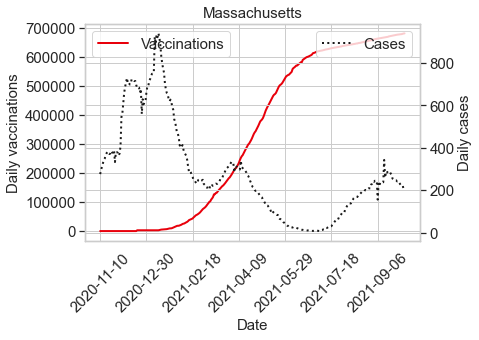

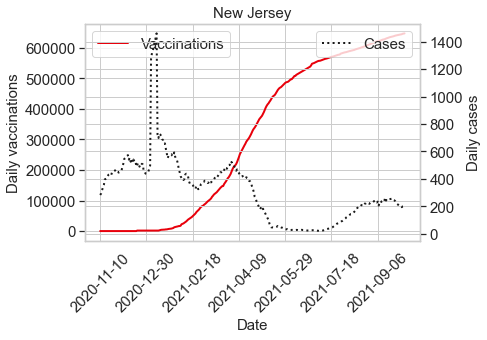

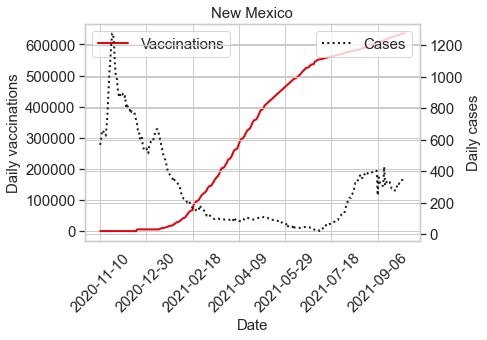

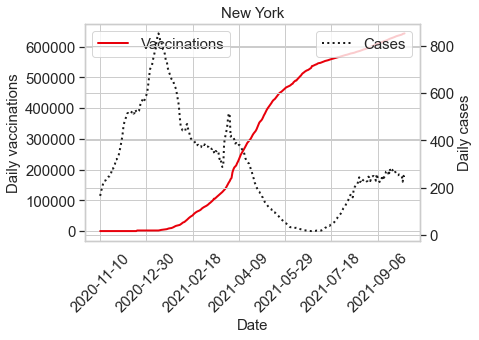

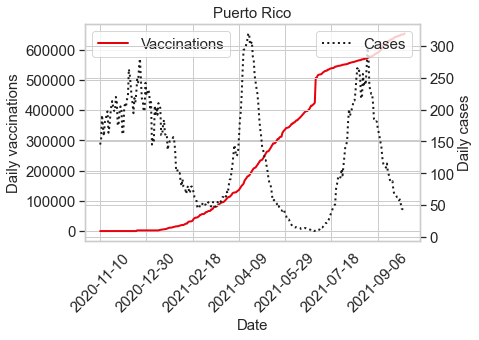

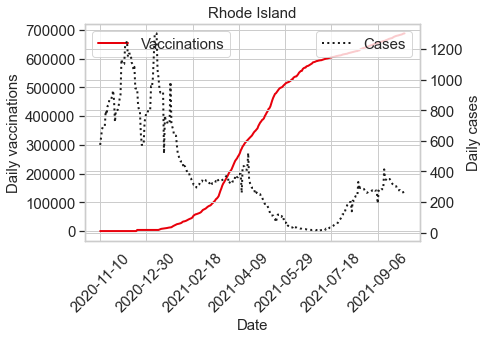

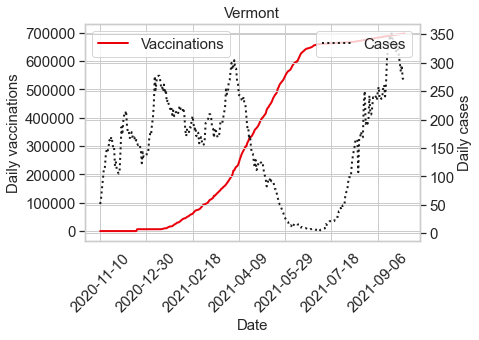

In [15]:
for target in donors:

    fig, ax = plt.subplots()

    plt.rcParams['figure.figsize'] = (6.0, 4.0)

    FONTSIZE = 15

    df1[target].loc['2020-11-1':].plot(ax = ax, color='r', label='Vaccinations')
    #plt.legend()
    plt.ylabel('Daily vaccinations', fontsize = FONTSIZE ), plt.xlabel('Date',fontsize = FONTSIZE)
    plt.yticks(fontsize = FONTSIZE)
    plt.legend(fontsize = FONTSIZE , loc = 'upper left')
    plt.xticks(fontsize = FONTSIZE)
    plt.xticks(rotation=45)
    #ax.axes.xaxis.set_ticklabels([])


    ax2 = ax.twinx()
    ax2.set_ylabel('Cases')
    df2[target].loc['2020-11-1':].plot(ax = ax2, secondary_y=True, color='k',linestyle=":", label='Cases')
    #plt.legend()
    plt.ylabel('Daily cases', fontsize = FONTSIZE ), plt.xlabel('Date',fontsize = FONTSIZE)

    plt.legend(fontsize = FONTSIZE , loc = 'upper right')
    plt.yticks(fontsize = FONTSIZE)
    #plt.xticks(fontsize = FONTSIZE)
    #ax2.axes.xaxis.set_ticklabels([])
    plt.title(target, fontsize = FONTSIZE)
    #plt.savefig('../Figures/COVID/'+target+'_deaths_cases.pdf', bbox_inches='tight')

    plt.show()


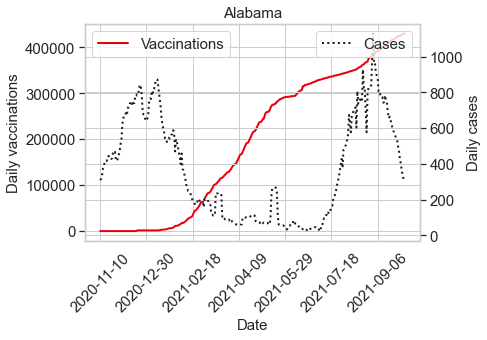

In [16]:

fig, ax = plt.subplots()

plt.rcParams['figure.figsize'] = (6.0, 4.0)


target ='Alabama'

FONTSIZE = 15

df1[target].loc['2020-11-1':].plot(ax = ax, color='r', label='Vaccinations')
#plt.legend()
plt.ylabel('Daily vaccinations', fontsize = FONTSIZE ), plt.xlabel('Date',fontsize = FONTSIZE)
plt.yticks(fontsize = FONTSIZE)
plt.legend(fontsize = FONTSIZE , loc = 'upper left')
plt.xticks(fontsize = FONTSIZE)
plt.xticks(rotation=45)
#ax.axes.xaxis.set_ticklabels([])


ax2 = ax.twinx()
ax2.set_ylabel('Cases')
df2[target].loc['2020-11-1':].plot(ax = ax2, secondary_y=True, color='k',linestyle=":", label='Cases')
#plt.legend()
plt.ylabel('Daily cases', fontsize = FONTSIZE ), plt.xlabel('Date',fontsize = FONTSIZE)

plt.legend(fontsize = FONTSIZE , loc = 'upper right')
plt.yticks(fontsize = FONTSIZE)
#plt.xticks(fontsize = FONTSIZE)
#ax2.axes.xaxis.set_ticklabels([])

#plt.savefig('../Figures/COVID/'+target+'_deaths_cases.pdf', bbox_inches='tight')
plt.title(target, fontsize = FONTSIZE)

plt.show()

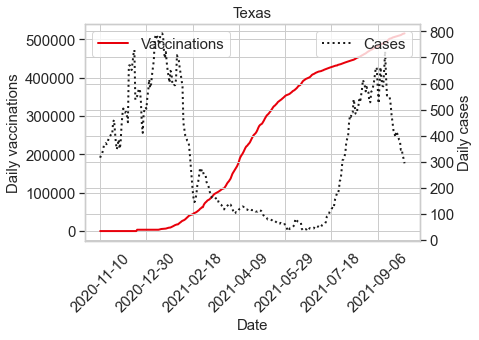

In [17]:

fig, ax = plt.subplots()

plt.rcParams['figure.figsize'] = (6.0, 4.0)


target ='Texas'

FONTSIZE = 15

df1[target].loc['2020-11-1':].plot(ax = ax, color='r', label='Vaccinations')
#plt.legend()
plt.ylabel('Daily vaccinations', fontsize = FONTSIZE ), plt.xlabel('Date',fontsize = FONTSIZE)
plt.yticks(fontsize = FONTSIZE)
plt.legend(fontsize = FONTSIZE , loc = 'upper left')
plt.xticks(fontsize = FONTSIZE)
plt.xticks(rotation=45)
#ax.axes.xaxis.set_ticklabels([])


ax2 = ax.twinx()
ax2.set_ylabel('Cases')
df2[target].loc['2020-11-1':].plot(ax = ax2, secondary_y=True, color='k',linestyle=":", label='Cases')
#plt.legend()
plt.ylabel('Daily cases', fontsize = FONTSIZE ), plt.xlabel('Date',fontsize = FONTSIZE)

plt.legend(fontsize = FONTSIZE , loc = 'upper right')
plt.yticks(fontsize = FONTSIZE)
#plt.xticks(fontsize = FONTSIZE)
#ax2.axes.xaxis.set_ticklabels([])

#plt.savefig('../Figures/COVID/'+target+'_deaths_cases.pdf', bbox_inches='tight')
plt.title(target, fontsize = FONTSIZE)

plt.show()

# Counterfactual analysis

In [18]:
full_vaccine_pop_adjusted.tail(1)

,Alabama,Alaska,American Samoa,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,District of Columbia,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
date,,,,,,,,,,,,,,,,,,,,,
2021-10-05,430725.130706,509282.409148,517915.661349,514789.625699,459916.217223,594304.501673,597796.634539,691302.832002,579064.331809,604882.188994,...,519429.520301,459322.752649,515874.927201,512495.484969,697523.514036,610371.6716,615306.872992,405349.003179,567948.902469,420195.625468


In [19]:

case_vaccine_adjusted, case_vaccine_adjusted_daily, vaccine_date_case= create_intervention_adjusted_data(all_cases_data_pop, vaccine_intervention, 7, ignore_nan=False)
deaths_vaccine_adjusted, deaths_vaccine_adjusted_daily, _ = create_intervention_adjusted_data(all_death_data_pop, vaccine_intervention, 7)
vaccine_adjusted, vaccine_adjusted_daily, vaccine_date = create_intervention_adjusted_data(df1, vaccine_intervention, 7, ignore_nan=False)



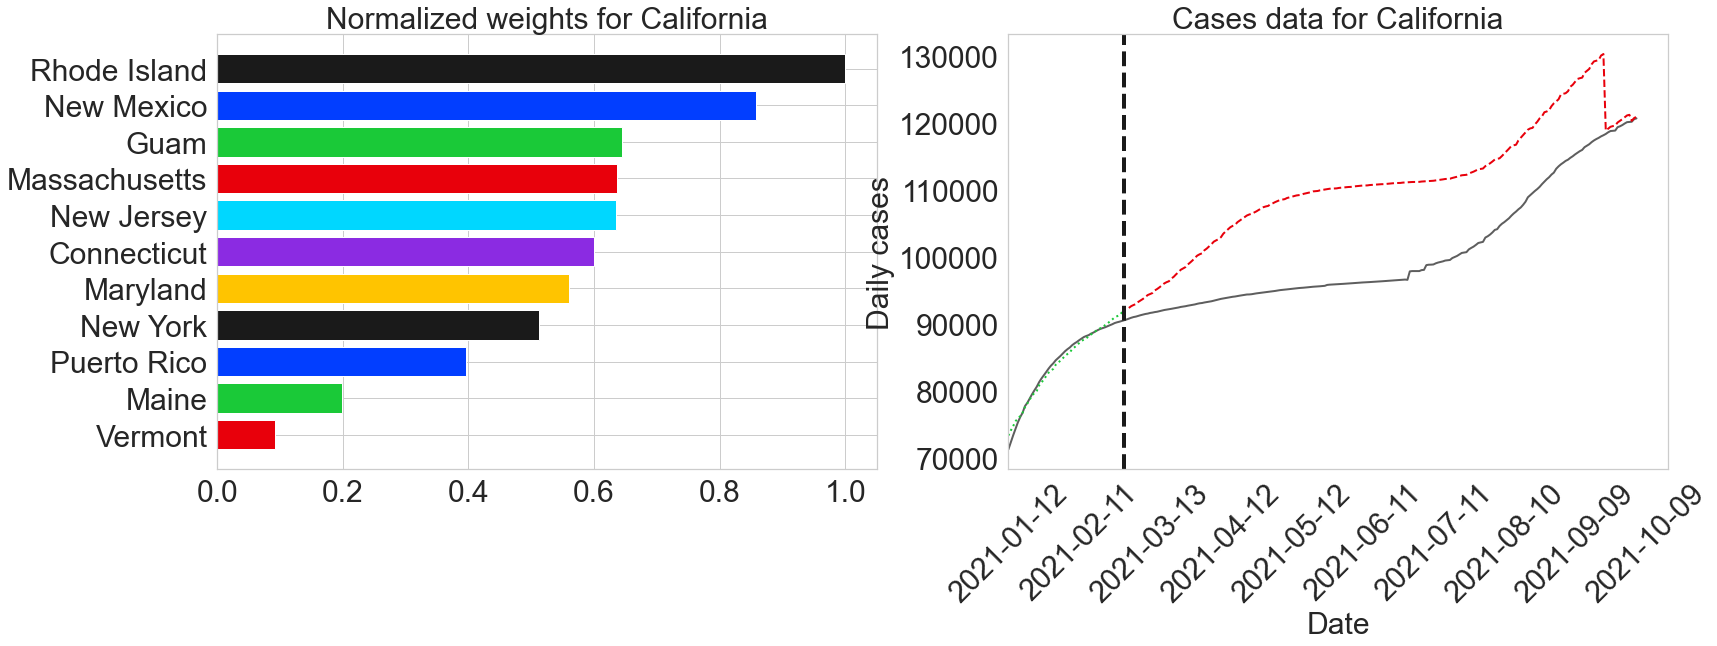

In [20]:

target = 'California'# 'Italy', 'Spain', 'United Kingdom', 'France']
singVals = 2
lambdas = [1]
projection_period=400
training_period=50
fig, axes = plt.subplots(1, 2, figsize=(26,8))

newdata = synth_control_predictions([case_vaccine_adjusted, vaccine_adjusted],projection_period, training_period, #, xlimit=(1,200)
                                            "Cases data", singVals, ylimit=[], savePlots=False, do_only=[target], showstates=10,
                               exclude=[target], figure=fig, axes=axes, donorPool=donors, 
                                    svdSpectrum=False, silent=True, showDonors=True, showPlots=True, lambdas=lambdas, mRSC=False, error_thresh=178463, FONTSIZE=30, yaxis = 'Daily cases', intervention_date_x_ticks = vaccine_date_case)



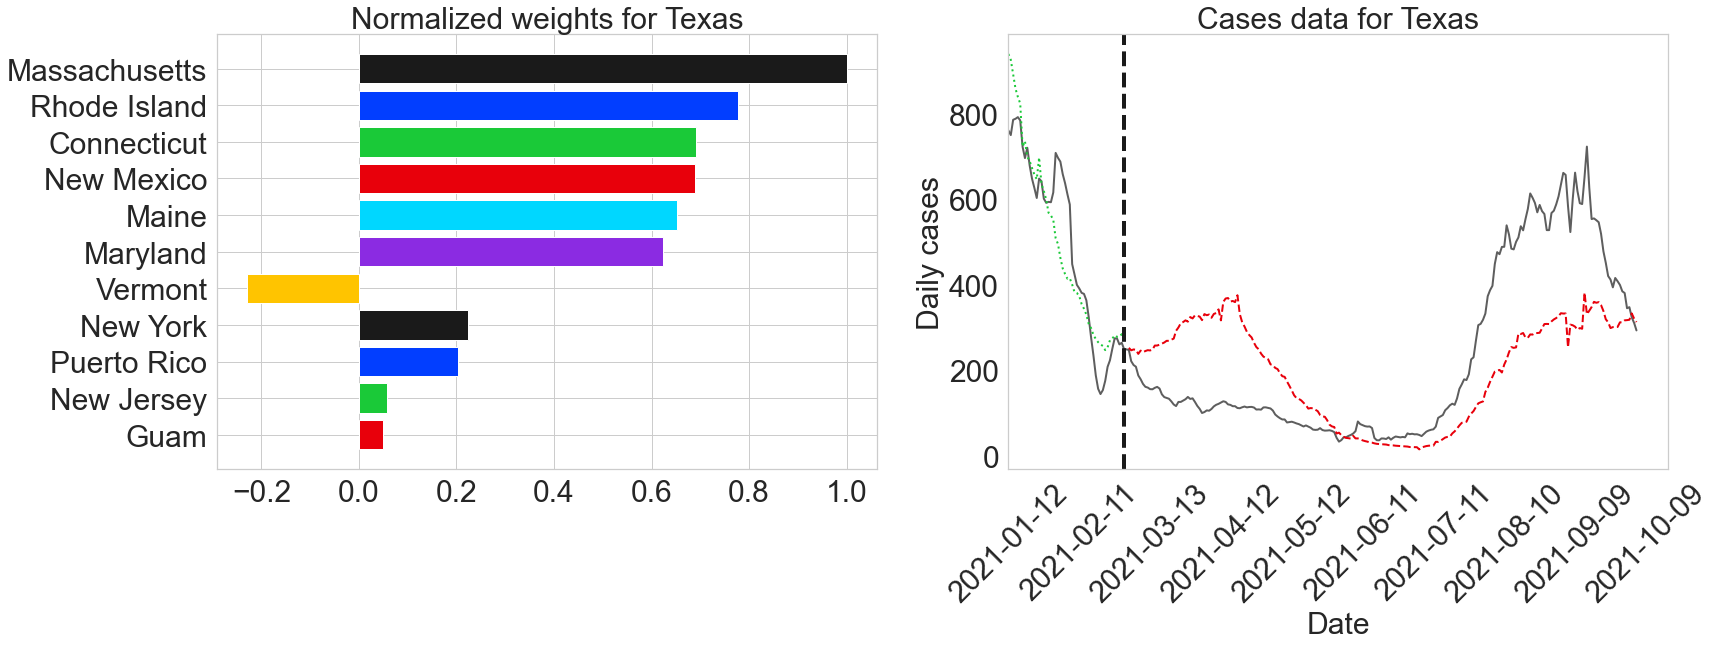

In [21]:

target = 'Texas'# 'Italy', 'Spain', 'United Kingdom', 'France']
singVals = 2
lambdas = [1]
projection_period=400
training_period=50
fig, axes = plt.subplots(1, 2, figsize=(26,8))

newdata = synth_control_predictions([case_vaccine_adjusted_daily, deaths_vaccine_adjusted_daily],projection_period, training_period, #, xlimit=(1,200)
                                            "Cases data", singVals, ylimit=[], savePlots=False, do_only=[target], showstates=10,
                               exclude=[target], figure=fig, axes=axes, donorPool=donors, 
                                    svdSpectrum=False, silent=True, showDonors=True, showPlots=True, lambdas=lambdas, mRSC=False, error_thresh=178463, FONTSIZE=30, yaxis = 'Daily cases', intervention_date_x_ticks = vaccine_date_case)



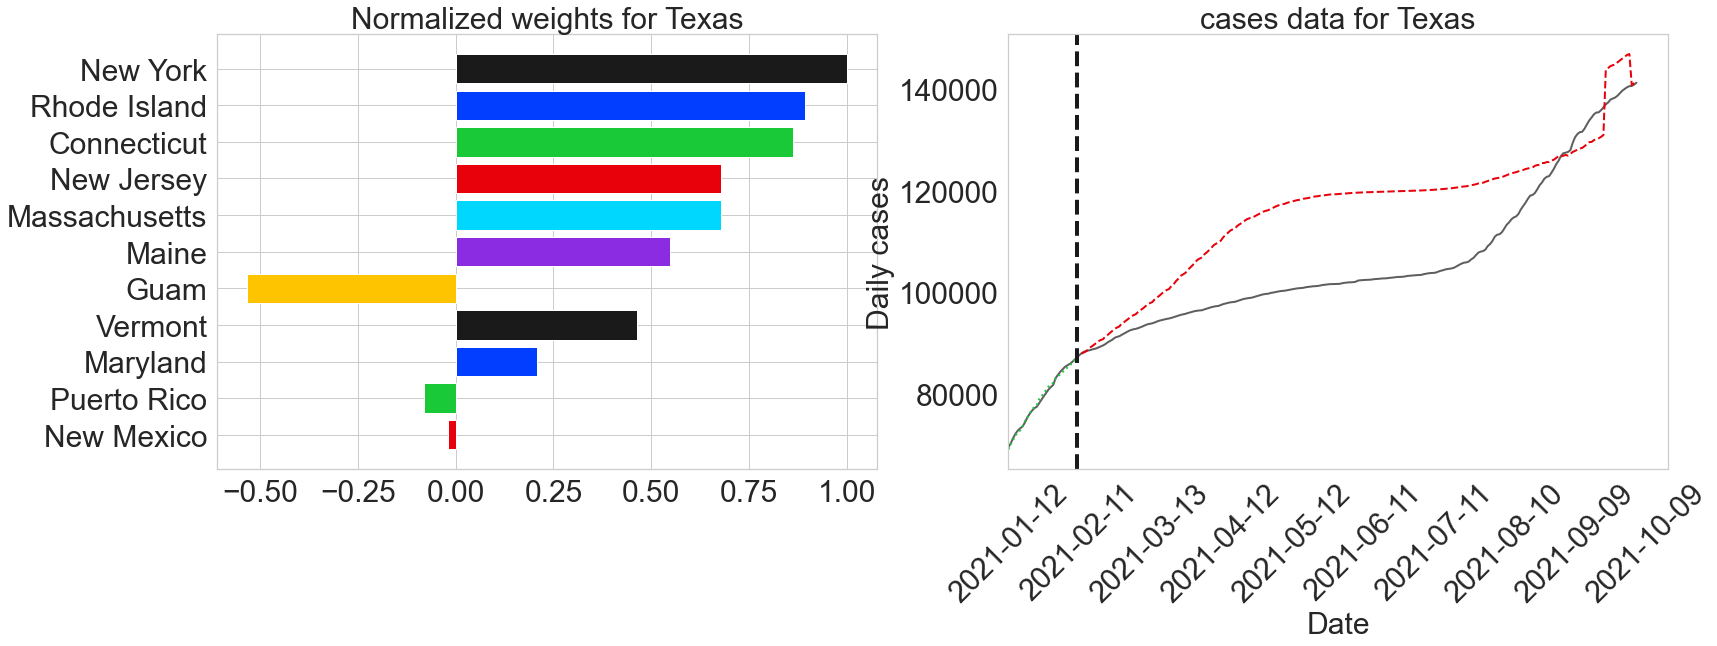

In [22]:

target = 'Texas'# 'Italy', 'Spain', 'United Kingdom', 'France']
singVals = 3
lambdas = [1]
projection_period=400
training_period=30
fig, axes = plt.subplots(1, 2, figsize=(26,8))

newdata = synth_control_predictions([case_vaccine_adjusted, vaccine_adjusted],projection_period, training_period, #, xlimit=(1,200)
                                            "cases data", singVals, ylimit=[], savePlots=False, do_only=[target], showstates=10,
                               exclude=[target], figure=fig, axes=axes, donorPool=donors, 
                                    svdSpectrum=False, silent=True, showDonors=True, showPlots=True, lambdas=lambdas, mRSC=False, error_thresh=178463, FONTSIZE=30, yaxis = 'Daily cases', intervention_date_x_ticks = vaccine_date_case)



1
target rank estimation:  1


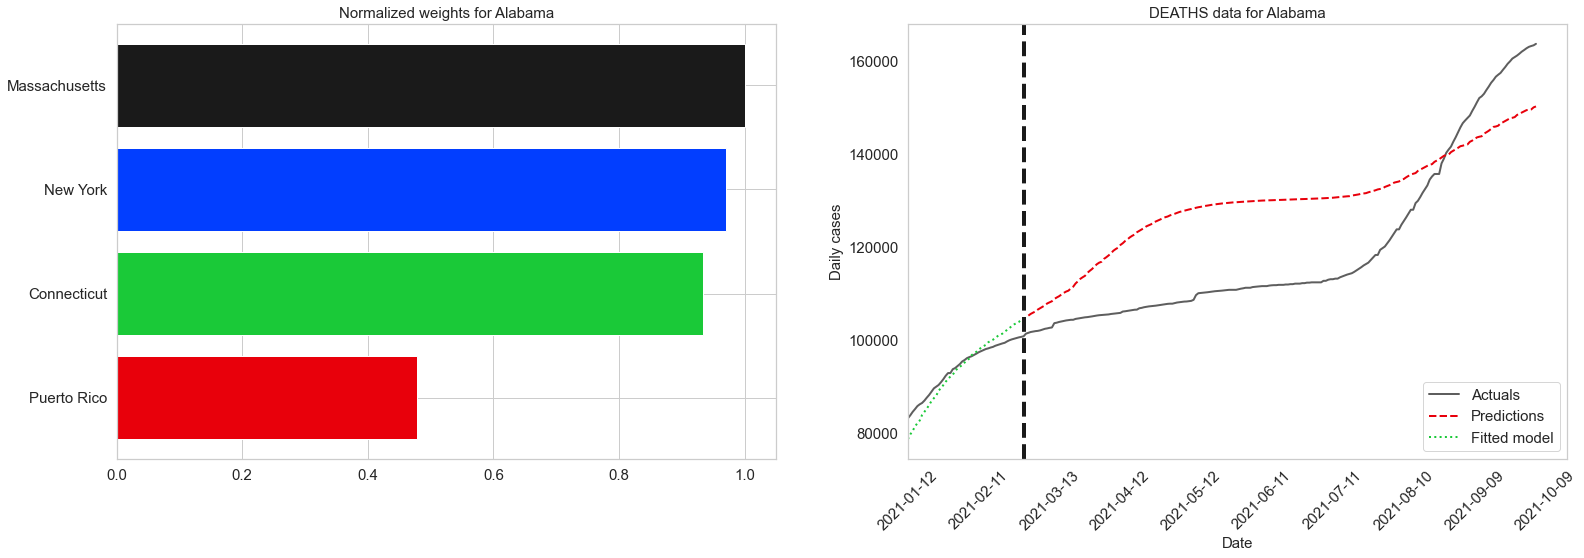

In [23]:
target = 'Alabama'# 'Italy', 'Spain', 'United Kingdom', 'France']
singVals = 2
lambdas = [1]
projection_period=400
training_period=50
rscModel = syn_model(target, singVals, [case_vaccine_adjusted, vaccine_adjusted], projection_period, training_period, otherStates=donors)

# to ensure there aren't too few donors
fig, axes = plt.subplots(1, 2, figsize = (26, 8))

try:
    rscModel.fit_model(filter_donor = True, filter_method = 'bin', singVals_estimate = True)
    print('target rank estimation: ', rscModel.kSingularValues)
except:
    rscModel.fit_model(filter_donor = True, filter_method = 'bin')
    print('target model rank estimation failed, rank 2 ued by default')


rscModel.plot(figure=fig, axes=axes, title_text="DEATHS data", ylimit=[], xlimit=[], logy=False, show_donors=True, tick_spacing=30, xaxis="Date", yaxis="Daily cases", intervention_date_x_ticks=vaccine_date_case, fontsize = FONTSIZE)

